In [2]:
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, make_scorer

TARGET = "tumour_type"
DIR_PATH = "./Datasets"
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (28, 10)

### Data Exploration & Feature Engineering

In [3]:
df = pd.read_csv(f"{DIR_PATH}/phg_signatures.csv").set_index("Unnamed: 0")
df.head()

pcawg_class    WGD  num_subclones  \
Unnamed: 0                                                                   
0009b464-b376-4fbc-8a56-da538269a02f   Ovary-AdenoCA   True            1.0   
003819bc-c415-4e76-887c-931d60ed39e7   CNS-PiloAstro  False            1.0   
0040b1b6-b07a-4b6e-90ef-133523eaf412       Liver-HCC  False            1.0   
00493087-9d9d-40ca-86d5-936f1b951c93       CNS-Oligo  False            1.0   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  Panc-Endocrine  False            2.0   

                                     tumour_type reported_sex  \
Unnamed: 0                                                      
0009b464-b376-4fbc-8a56-da538269a02f   Recurrent       Female   
003819bc-c415-4e76-887c-931d60ed39e7     Primary       Female   
0040b1b6-b07a-4b6e-90ef-133523eaf412     Primary         Male   
00493087-9d9d-40ca-86d5-936f1b951c93     Primary       Female   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa     Primary       Female   

                                      donor_survival_time  \
Unnamed: 0                                                  
0009b464-b376-4fbc-8a56-da538269a02f               1972.0   
003819bc-c415-4e76-887c-931d60ed39e7                244.0   
0040b1b6-b07a-4b6e-90ef-133523eaf412               1905.0   
00493087-9d9d-40ca-86d5-936f1b951c93                  NaN   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa                  7.0   

                                      donor_age_at_diagnosis tumour_stage  \
Unnamed: 0                                                                  
0009b464-b376-4fbc-8a56-da538269a02f                    54.0          NaN   
003819bc-c415-4e76-887c-931d60ed39e7                     4.0          NaN   
0040b1b6-b07a-4b6e-90ef-133523eaf412                    73.0          NaN   
00493087-9d9d-40ca-86d5-936f1b951c93                    47.0          NaN   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa                    59.0       T2N1MX   

                                                       tumour_grade  \
Unnamed: 0                                                            
0009b464-b376-4fbc-8a56-da538269a02f                            NaN   
003819bc-c415-4e76-887c-931d60ed39e7                              1   
0040b1b6-b07a-4b6e-90ef-133523eaf412                             G2   
00493087-9d9d-40ca-86d5-936f1b951c93                            NaN   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  2 - Moderately differentiated   

                                     first_therapy_type  ...     SBS85  \
Unnamed: 0                                               ...             
0009b464-b376-4fbc-8a56-da538269a02f                NaN  ...  0.004170   
003819bc-c415-4e76-887c-931d60ed39e7                NaN  ...  0.011223   
0040b1b6-b07a-4b6e-90ef-133523eaf412       no treatment  ...  0.010256   
00493087-9d9d-40ca-86d5-936f1b951c93                NaN  ...  0.034194   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa                NaN  ...  0.002131   

                                         SBS86     SBS87     SBS88     SBS89  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.032632  0.009180  0.004538  0.015247   
003819bc-c415-4e76-887c-931d60ed39e7  0.000018  0.043297  0.002587  0.000110   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.001064  0.000472  0.006128  0.014017   
00493087-9d9d-40ca-86d5-936f1b951c93  0.007644  0.066593  0.003875  0.008409   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.006881  0.014572  0.005315  0.034945   

                                         SBS90     SBS91     SBS92     SBS93  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.023516  0.001096  0.001524  0.041314   
003819bc-c415-4e76-887c-931d60ed39e7  0.001679  0.000330  0.008414  0.012260   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.003671  0.002160  0.015290  0.010472   
00493087-9d9d-40ca-86d5-936f1b951c93  0.001092  0.004163  0.013443  0.012461   
00508f2b-36b

In [4]:
df = df[[column for column in df.columns if "SBS" in column or TARGET == column]]
df.head()

tumour_type      SBS1      SBS2  \
Unnamed: 0                                                             
0009b464-b376-4fbc-8a56-da538269a02f   Recurrent  0.008850  0.016874   
003819bc-c415-4e76-887c-931d60ed39e7     Primary  0.004316  0.003587   
0040b1b6-b07a-4b6e-90ef-133523eaf412     Primary  0.003217  0.000678   
00493087-9d9d-40ca-86d5-936f1b951c93     Primary  0.091871  0.000089   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa     Primary  0.018977  0.001370   

                                          SBS3      SBS4      SBS5      SBS6  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.054517  0.019504  0.022650  0.003921   
003819bc-c415-4e76-887c-931d60ed39e7  0.000254  0.010579  0.086123  0.000176   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.015799  0.014538  0.014367  0.004027   
00493087-9d9d-40ca-86d5-936f1b951c93  0.011195  0.061277  0.055128  0.023751   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.024589  0.011517  0.031549  0.110884   

                                         SBS7a     SBS7b     SBS7c  ...  \
Unnamed: 0                                                          ...   
0009b464-b376-4fbc-8a56-da538269a02f  0.002985  0.001309  0.004520  ...   
003819bc-c415-4e76-887c-931d60ed39e7  0.000167  0.002125  0.054186  ...   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.000527  0.001565  0.000627  ...   
00493087-9d9d-40ca-86d5-936f1b951c93  0.000442  0.000266  0.001722  ...   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.006500  0.009127  0.000110  ...   

                                         SBS85     SBS86     SBS87     SBS88  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.004170  0.032632  0.009180  0.004538   
003819bc-c415-4e76-887c-931d60ed39e7  0.011223  0.000018  0.043297  0.002587   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.010256  0.001064  0.000472  0.006128   
00493087-9d9d-40ca-86d5-936f1b951c93  0.034194  0.007644  0.066593  0.003875   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.002131  0.006881  0.014572  0.005315   

                                         SBS89     SBS90     SBS91     SBS92  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.015247  0.023516  0.001096  0.001524   
003819bc-c415-4e76-887c-931d60ed39e7  0.000110  0.001679  0.000330  0.008414   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.014017  0.003671  0.002160  0.015290   
00493087-9d9d-40ca-86d5-936f1b951c93  0.008409  0.001092  0.004163  0.013443   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.034945  0.000375  0.024285  0.001300   

                                         SBS93     SBS94  
Unnamed: 0                                                
0009b464-b376-4fbc-8a56-da538269a02f  0.041314  0.074747  
003819bc-c415-4e76-887c-931d60ed39e7  0.012260  0.010864  
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.010472  0.012708  
00493087-9d9d-40ca-86d5-936f1b951c93  0.012461  0.046001  
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.002455  0.023321  

[5 rows x 79 columns]

In [5]:
MUTATION_COLS = [column for column in df.columns if column != TARGET]
df.describe().T

count      mean       std           min       25%       50%  \
SBS1   18947.0  0.029247  0.032261  6.420926e-06  0.005538  0.019845   
SBS2   18947.0  0.016659  0.036024  2.201581e-08  0.001113  0.003393   
SBS3   18947.0  0.038309  0.044053  3.646269e-07  0.008568  0.024061   
SBS4   18947.0  0.015902  0.028924  3.121100e-07  0.002772  0.006687   
SBS5   18947.0  0.030592  0.043232  4.613292e-07  0.007866  0.018507   
...        ...       ...       ...           ...       ...       ...   
SBS90  18947.0  0.010128  0.014544  3.942043e-08  0.002028  0.005907   
SBS91  18947.0  0.005608  0.007806  2.483039e-09  0.001405  0.003927   
SBS92  18947.0  0.018902  0.030220  9.082248e-08  0.004146  0.010021   
SBS93  18947.0  0.019081  0.027936  7.957188e-08  0.002672  0.009593   
SBS94  18947.0  0.039369  0.046579  1.473853e-06  0.011214  0.027386   

            75%       max  
SBS1   0.042126  0.573056  
SBS2   0.012620  0.468217  
SBS3   0.051519  0.687517  
SBS4   0.015505  0.616549  
SBS5   0.037532  0.827369  
...         ...       ...  
SBS90  0.013938  0.828851  
SBS91  0.007698  0.338572  
SBS92  0.022277  0.846877  
SBS93  0.024240  0.892275  
SBS94  0.051234  0.942930  

[78 rows x 8 columns]

In [6]:
print(f"Number of NaN's - {df.isna().sum().sum()}")
print(f"Max across all - {df.describe().T['max'].max()}")
print(f"Min across all - {df.describe().T['min'].min()}")

Number of NaN's - 12752
Max across all - 0.9429304558147028
Min across all - 1.7701031252414227e-09


In [7]:
df = df.dropna()
df = df[df['tumour_type'].isin(['Primary', 'Metastatic'])]
df.shape

(6163, 79)

<AxesSubplot:>

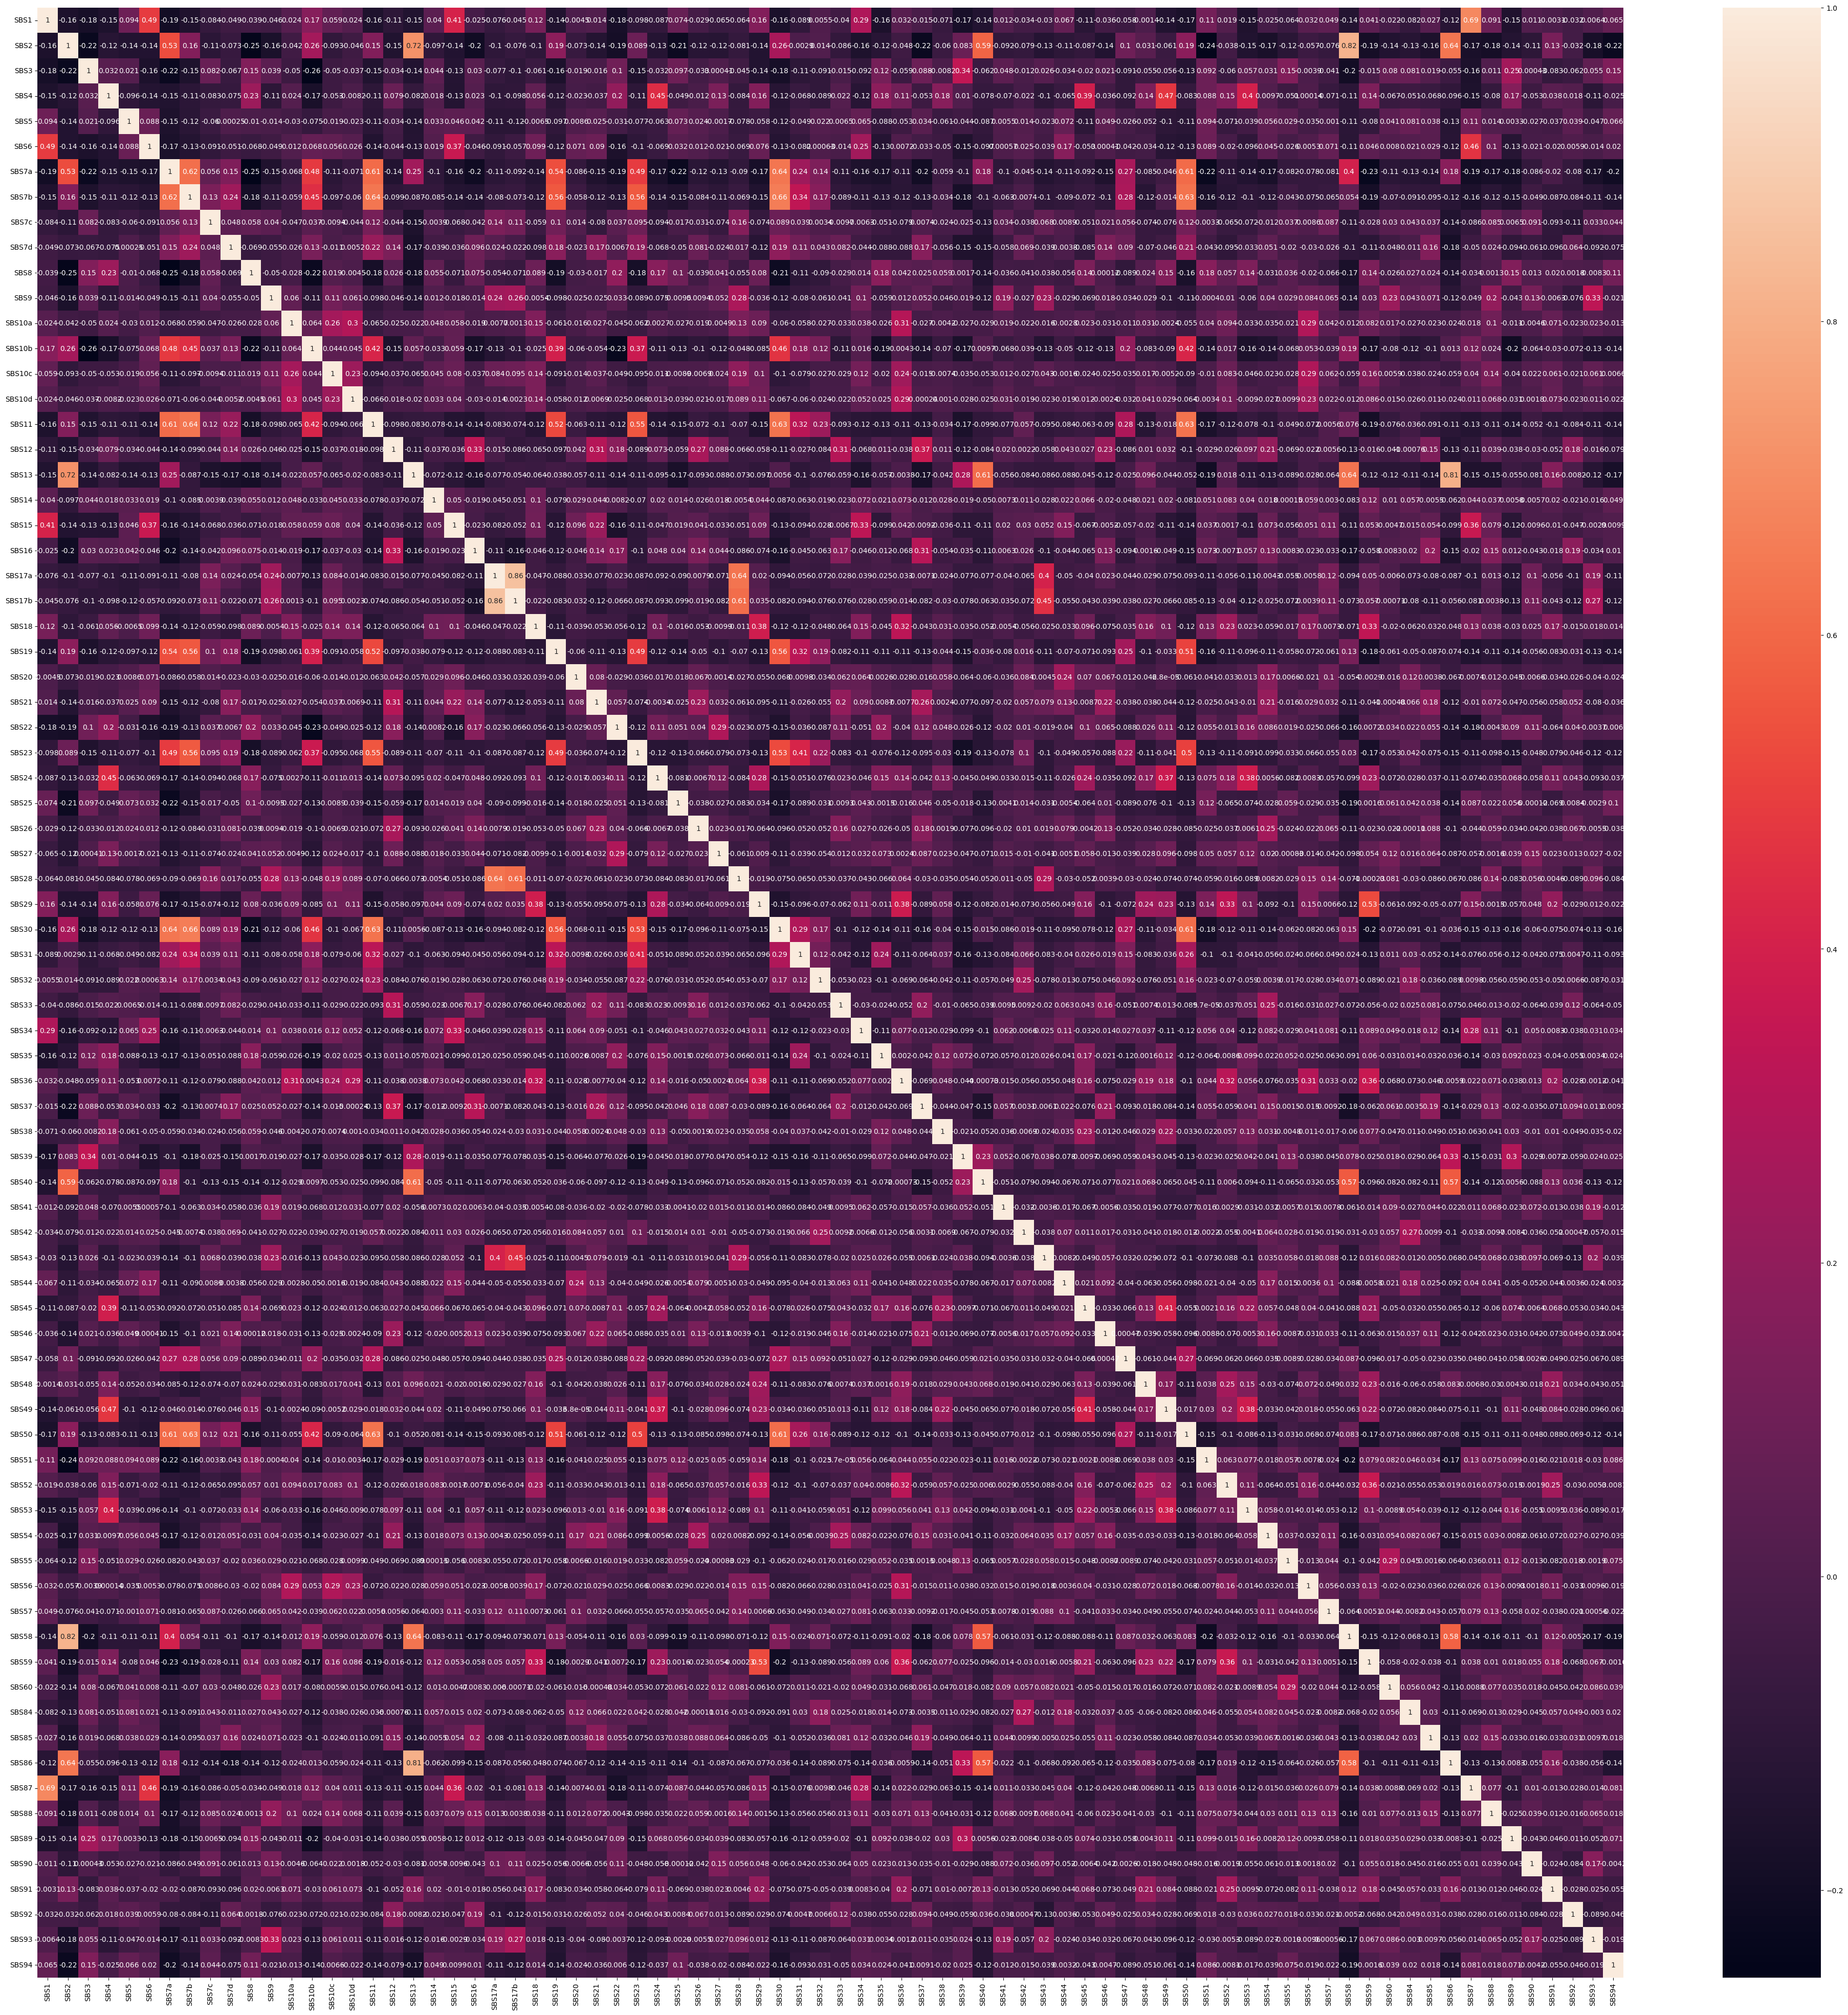

In [8]:
plt.rcParams["figure.figsize"] = (50, 50)
sns.heatmap(df.corr(), annot = True)

In [9]:
df_label = df.copy(deep = True)
label_to_encode = [TARGET]
encoders_dict = defaultdict(LabelEncoder)

for col in label_to_encode:
    df_label[col] = df[col].apply(str)
    df_label[col] = encoders_dict[col].fit_transform(df_label[col])

df_label.head()

tumour_type      SBS1      SBS2  \
Unnamed: 0                                                              
003819bc-c415-4e76-887c-931d60ed39e7            1  0.004316  0.003587   
0040b1b6-b07a-4b6e-90ef-133523eaf412            1  0.003217  0.000678   
00493087-9d9d-40ca-86d5-936f1b951c93            1  0.091871  0.000089   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa            1  0.018977  0.001370   
005794f1-5a87-45b5-9811-83ddf6924568            1  0.004149  0.001245   

                                          SBS3      SBS4      SBS5      SBS6  \
Unnamed: 0                                                                     
003819bc-c415-4e76-887c-931d60ed39e7  0.000254  0.010579  0.086123  0.000176   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.015799  0.014538  0.014367  0.004027   
00493087-9d9d-40ca-86d5-936f1b951c93  0.011195  0.061277  0.055128  0.023751   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.024589  0.011517  0.031549  0.110884   
005794f1-5a87-45b5-9811-83ddf6924568  0.071443  0.027644  0.041967  0.000223   

                                         SBS7a     SBS7b     SBS7c  ...  \
Unnamed: 0                                                          ...   
003819bc-c415-4e76-887c-931d60ed39e7  0.000167  0.002125  0.054186  ...   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.000527  0.001565  0.000627  ...   
00493087-9d9d-40ca-86d5-936f1b951c93  0.000442  0.000266  0.001722  ...   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.006500  0.009127  0.000110  ...   
005794f1-5a87-45b5-9811-83ddf6924568  0.000772  0.003687  0.026620  ...   

                                         SBS85     SBS86     SBS87     SBS88  \
Unnamed: 0                                                                     
003819bc-c415-4e76-887c-931d60ed39e7  0.011223  0.000018  0.043297  0.002587   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.010256  0.001064  0.000472  0.006128   
00493087-9d9d-40ca-86d5-936f1b951c93  0.034194  0.007644  0.066593  0.003875   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.002131  0.006881  0.014572  0.005315   
005794f1-5a87-45b5-9811-83ddf6924568  0.000848  0.002754  0.006760  0.008834   

                                         SBS89     SBS90     SBS91     SBS92  \
Unnamed: 0                                                                     
003819bc-c415-4e76-887c-931d60ed39e7  0.000110  0.001679  0.000330  0.008414   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.014017  0.003671  0.002160  0.015290   
00493087-9d9d-40ca-86d5-936f1b951c93  0.008409  0.001092  0.004163  0.013443   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.034945  0.000375  0.024285  0.001300   
005794f1-5a87-45b5-9811-83ddf6924568  0.040637  0.002801  0.003005  0.011455   

                                         SBS93     SBS94  
Unnamed: 0                                                
003819bc-c415-4e76-887c-931d60ed39e7  0.012260  0.010864  
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.010472  0.012708  
00493087-9d9d-40ca-86d5-936f1b951c93  0.012461  0.046001  
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.002455  0.023321  
005794f1-5a87-45b5-9811-83ddf6924568  0.008315  0.079724  

[5 rows x 79 columns]

#### Check the best features, create their combinations

In [ ]:
X, y = df_label.drop(TARGET, axis=1), df_label[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y)

fit_kwargs = {
    "eval_metric" : "auc", 
    "eval_set": [(X_train, y_train), (X_test, y_test)], 
    "early_stopping_rounds": 20,
    "verbose": -100
}
model = LGBMClassifier()
model.fit(X_train, y_train, **fit_kwargs)
feature_imp = sorted([(imp, col) for imp, col in zip(model.feature_importances_, X.columns) if imp > 0])
feature_imp = pd.DataFrame(feature_imp, columns=['Value','Feature'])
top_features = feature_imp.sort_values(by = "Value", ascending = False)["Feature"][:20].values
top_features

In [ ]:
es = ft.EntitySet(id = 'mutation_activities')
es = es.add_dataframe(dataframe_name = 'mutation_activities_df', dataframe = df_label[top_features], index = "Unnamed: 0")
es

In [ ]:
# transformations_list = ['subtract_numeric', 'divide_numeric', 'add_numeric', 'multiply_numeric', 'natural_logarithm', 'percentile']
transformations_list = ['add_numeric',  'divide_numeric']
features, feature_names = ft.dfs(entityset = es, target_dataframe_name = 'mutation_activities_df', trans_primitives = transformations_list)

In [ ]:
cols = [col for col in features.reset_index().columns if col not in top_features]
additional_features = features.reset_index()[cols].drop("Unnamed: 0", axis = 1)
additional_features.index = df_label.index
additional_features.shape

In [ ]:
df_label_add_features = pd.concat((df_label, additional_features), axis = 1)
df_label_add_features.info()

#### Add clusters

For n_clusters = 2 The average silhouette_score is : 0.2549282786140099
For n_clusters = 3 The average silhouette_score is : 0.26132884495667047
For n_clusters = 4 The average silhouette_score is : 0.1247438911459273
For n_clusters = 5 The average silhouette_score is : 0.1430778033500297
For n_clusters = 6 The average silhouette_score is : 0.1479343299650955
For n_clusters = 7 The average silhouette_score is : 0.14454644826253107
For n_clusters = 8 The average silhouette_score is : 0.1587465584643382
For n_clusters = 9 The average silhouette_score is : 0.15297509141366544
For n_clusters = 10 The average silhouette_score is : 0.15739584136265114
For n_clusters = 11 The average silhouette_score is : 0.15288519978140097
For n_clusters = 12 The average silhouette_score is : 0.1364917101010778
For n_clusters = 13 The average silhouette_score is : 0.15210004766611118
For n_clusters = 14 The average silhouette_score is : 0.14127796218469252
For n_clusters = 15 The average silhouette_score is 

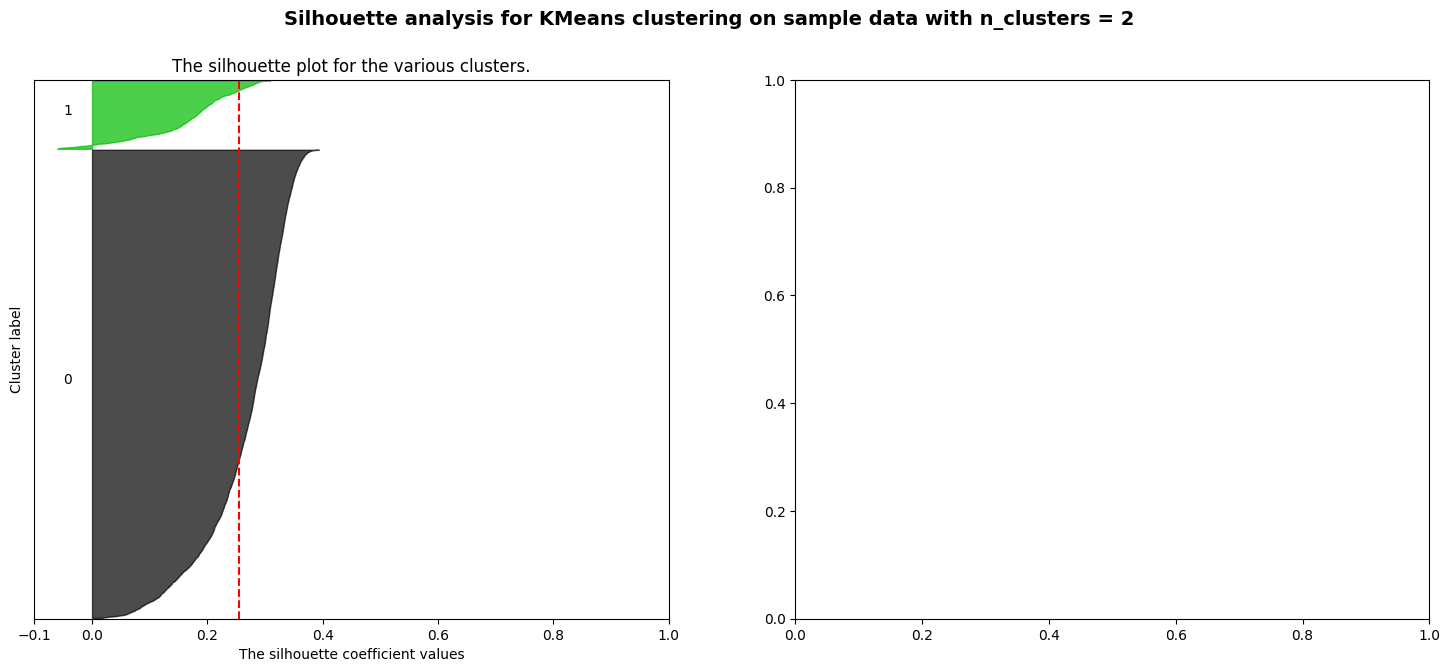

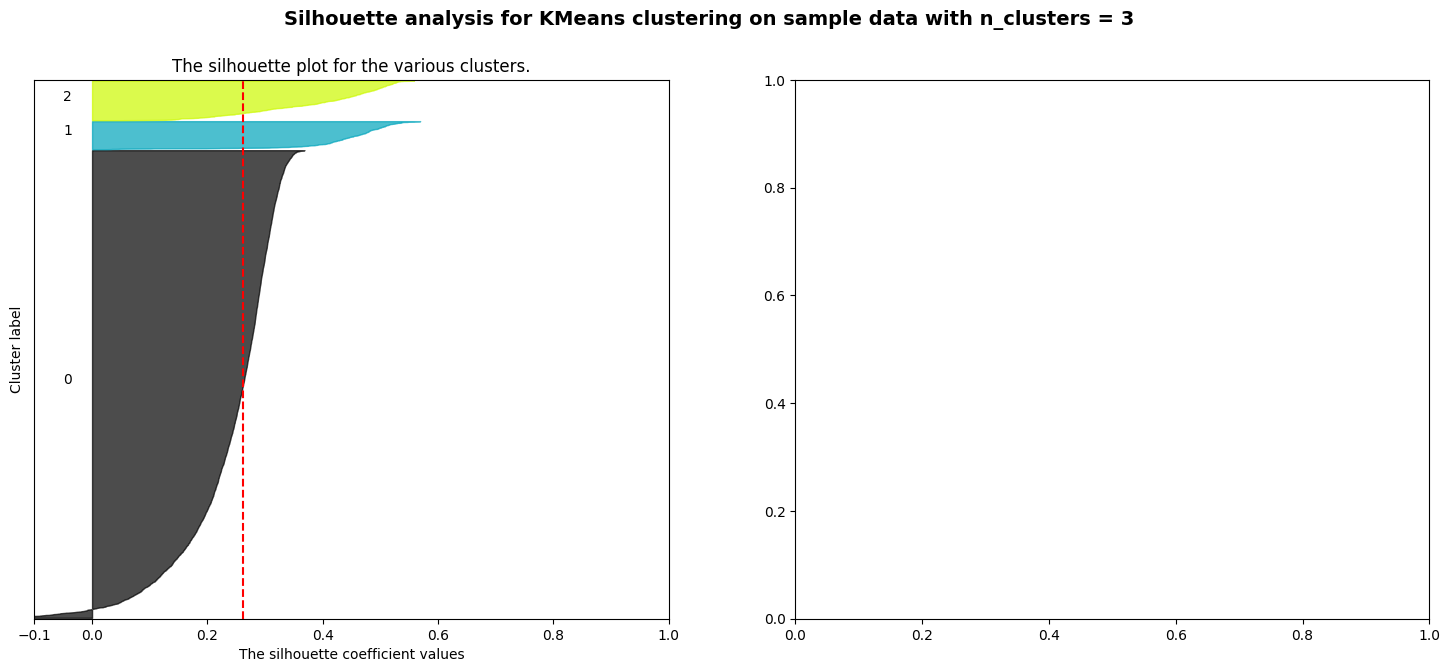

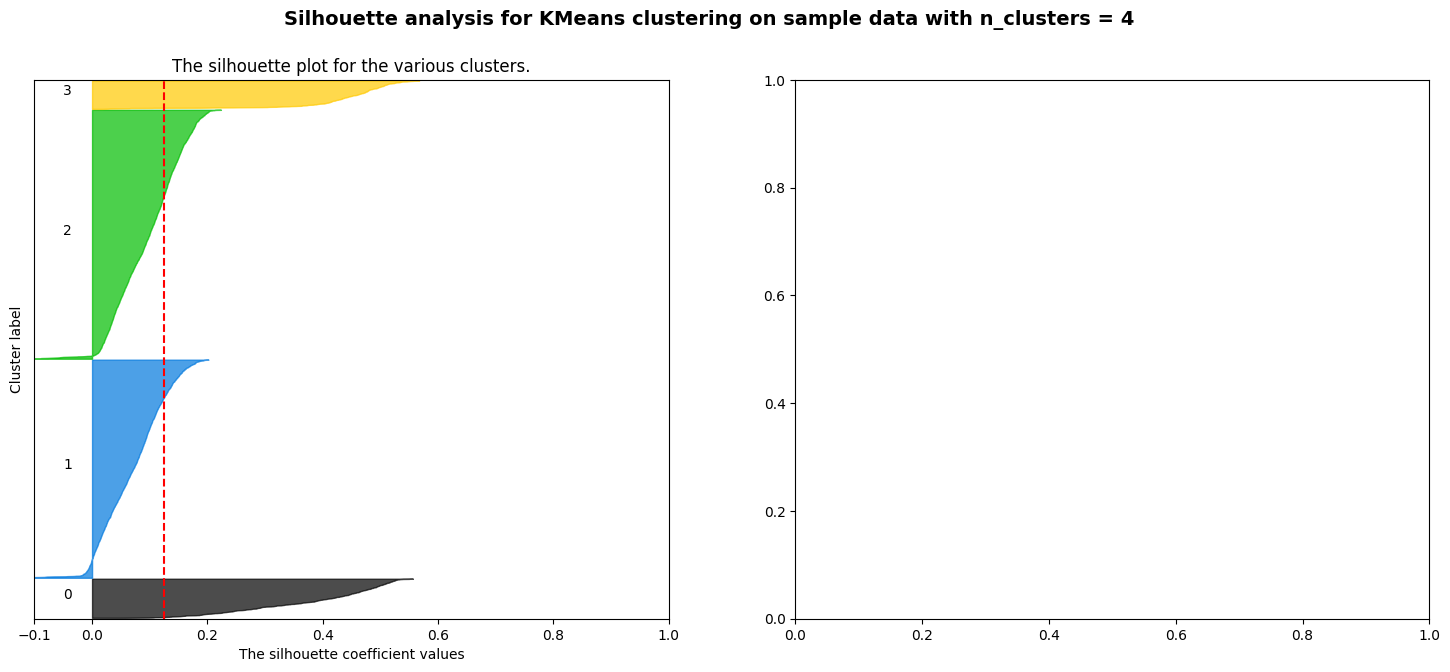

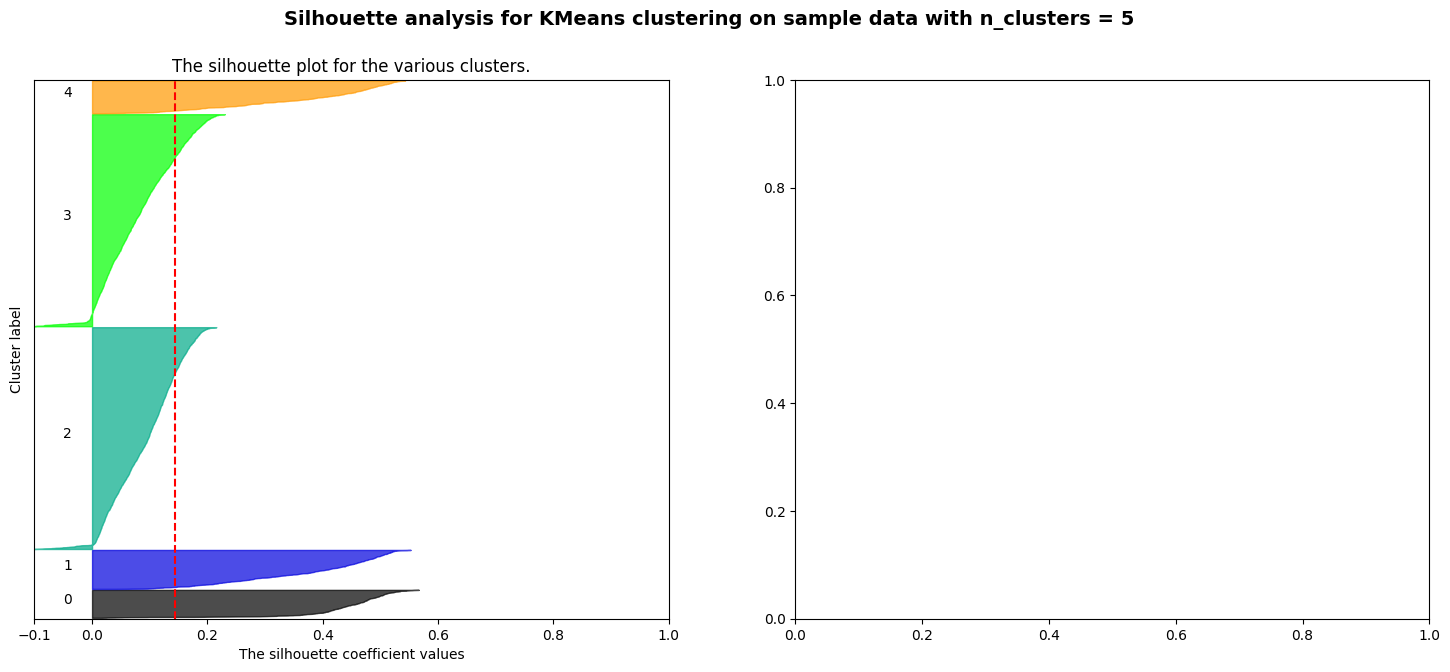

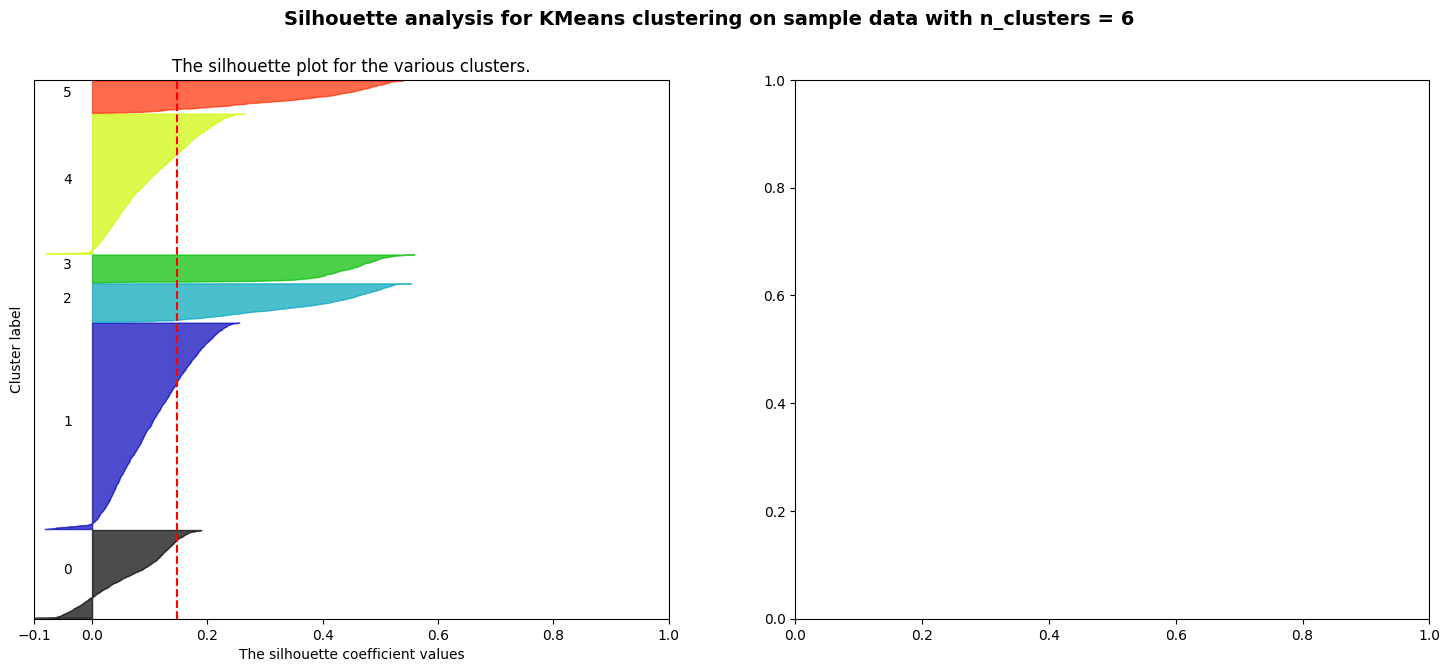

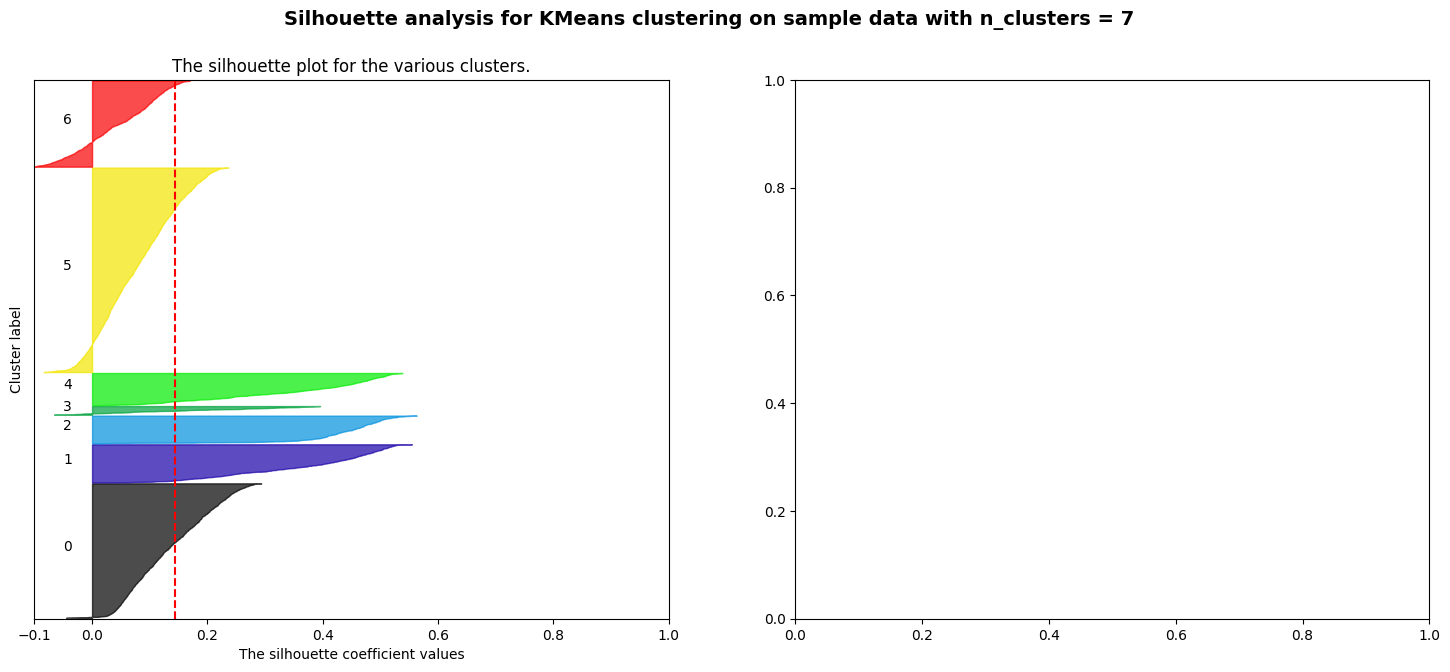

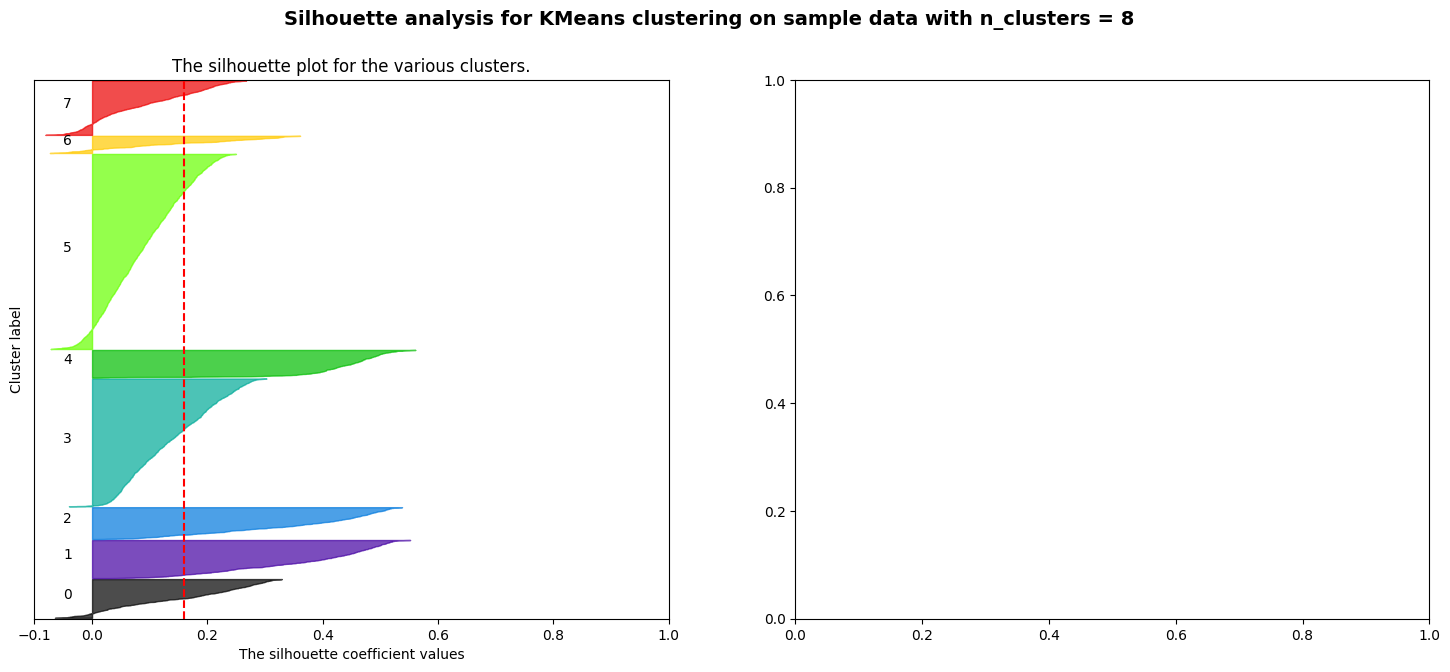

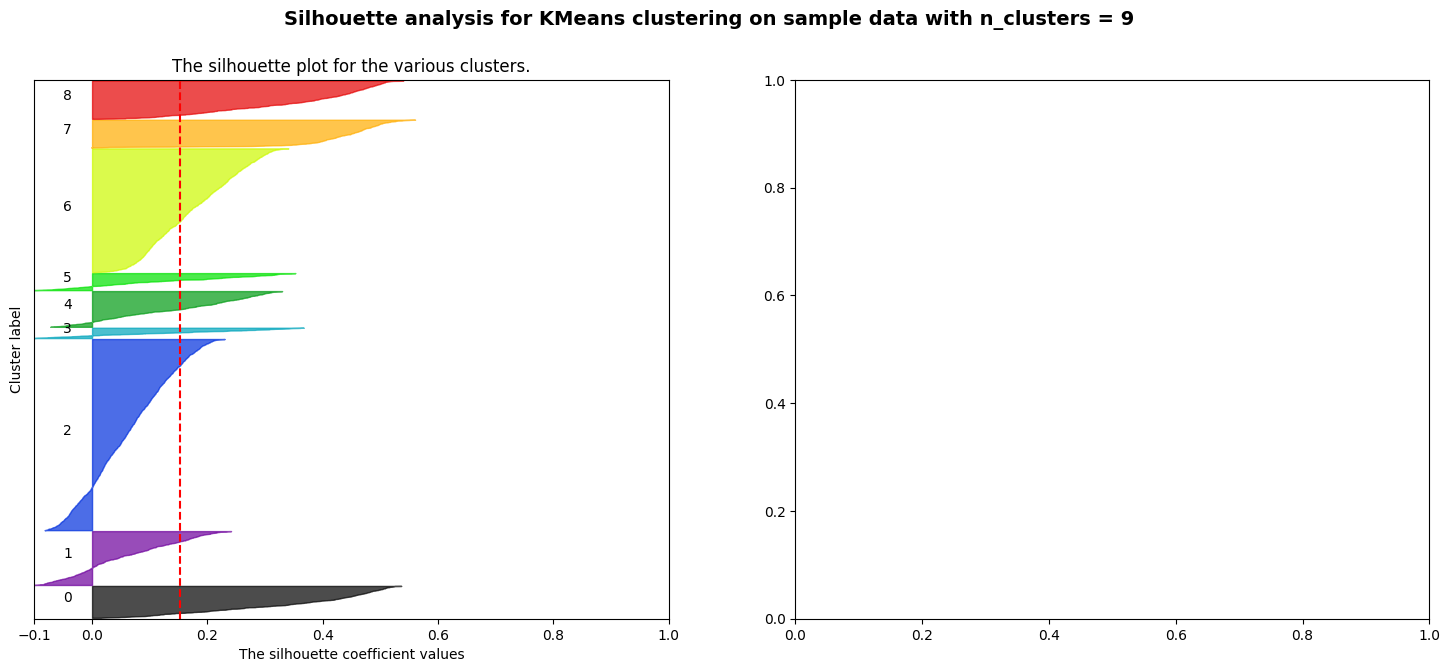

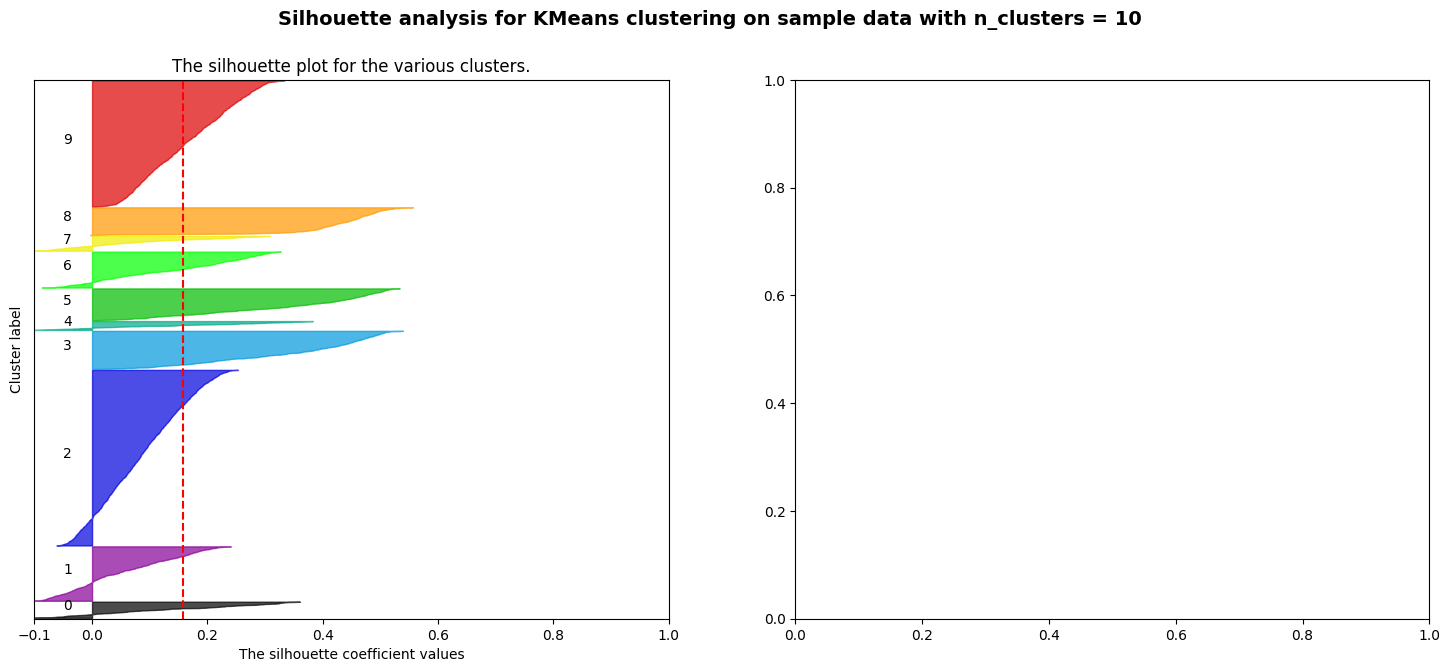

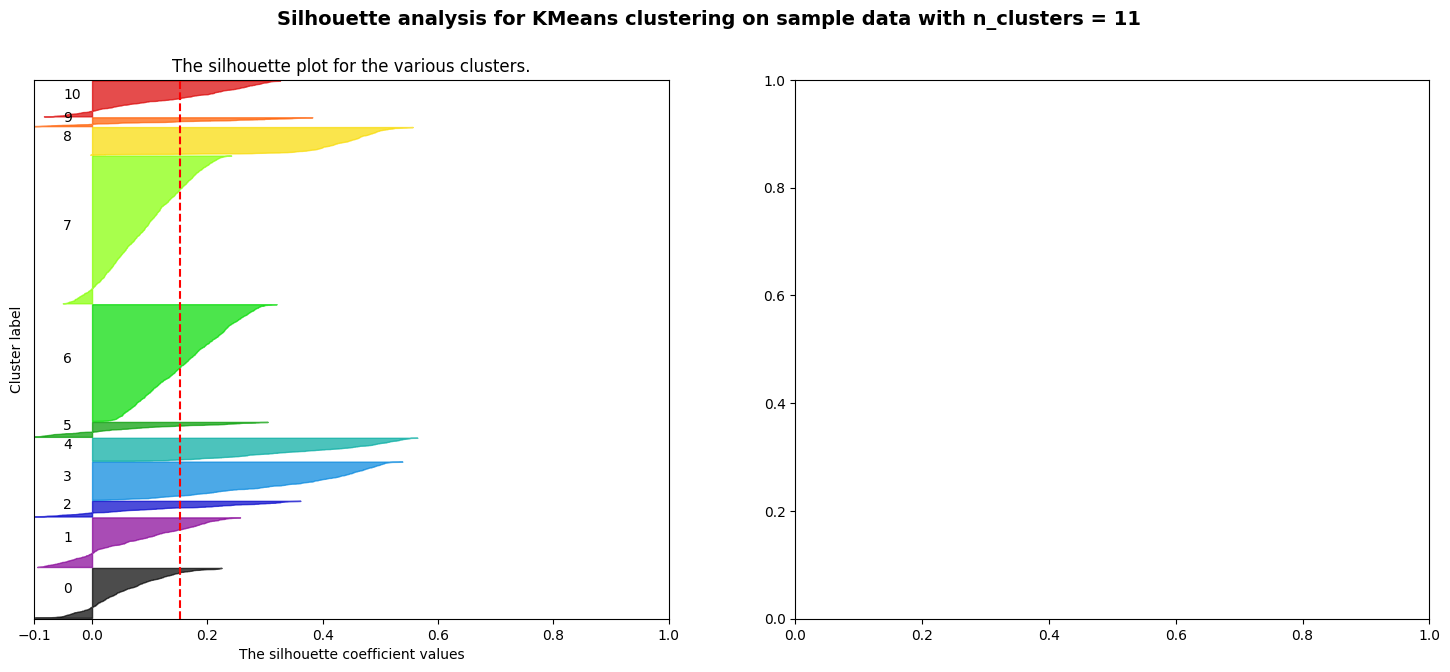

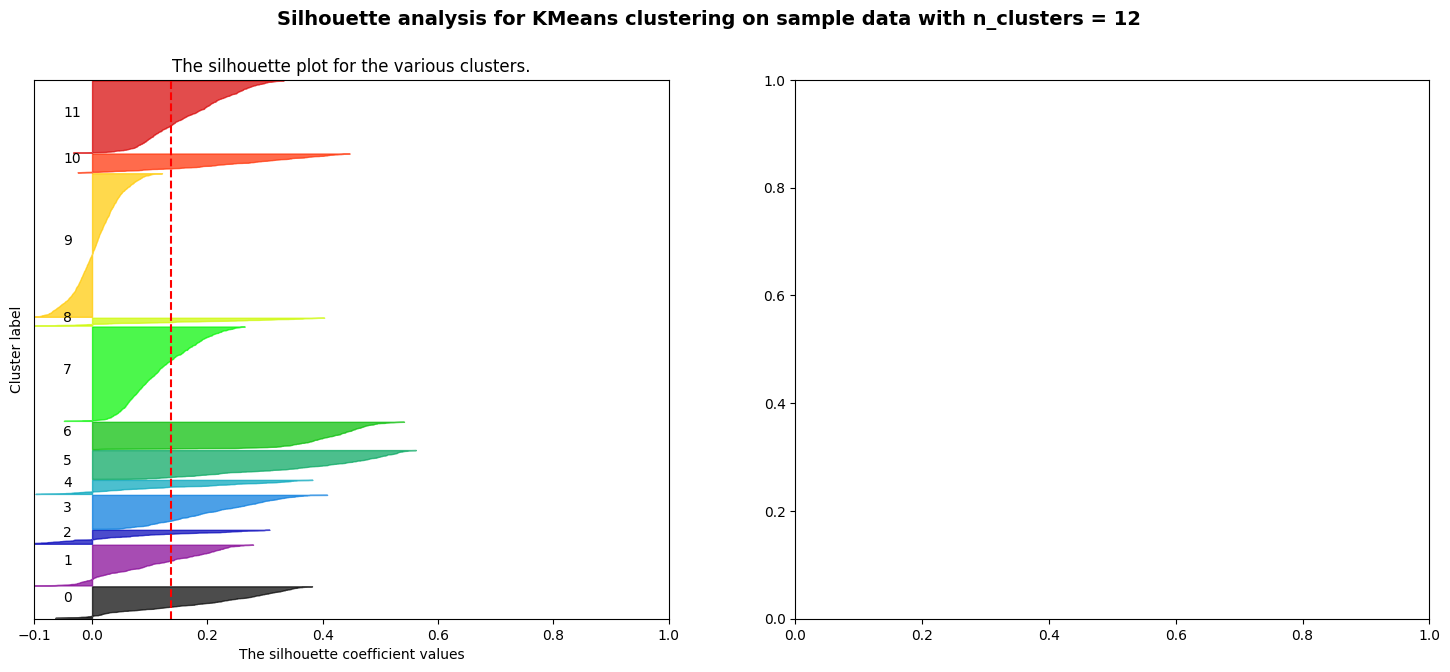

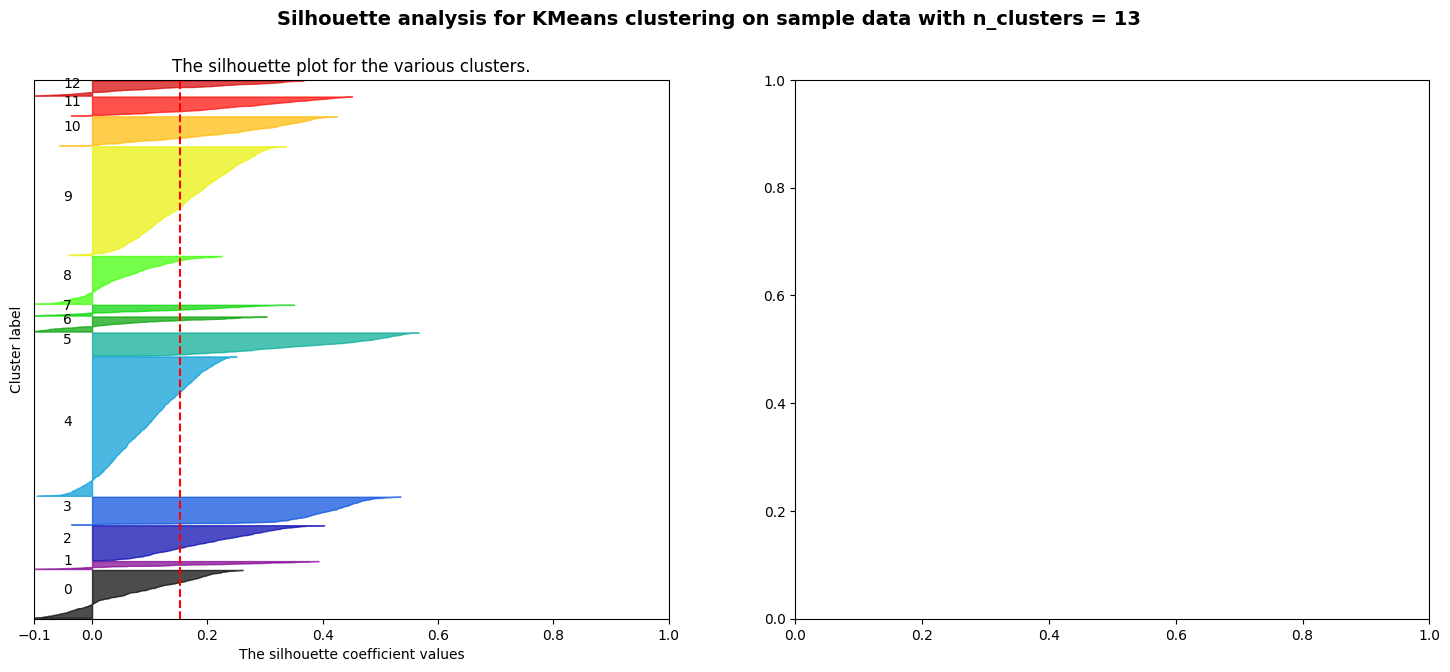

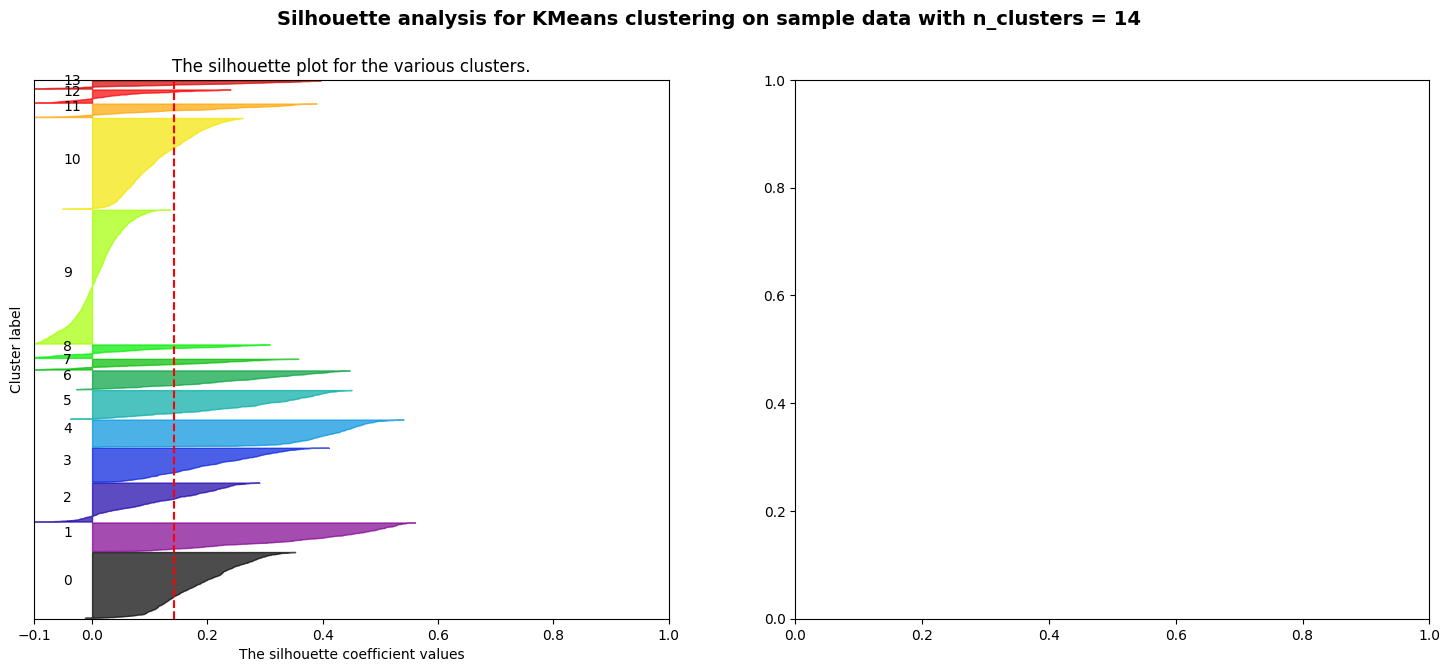

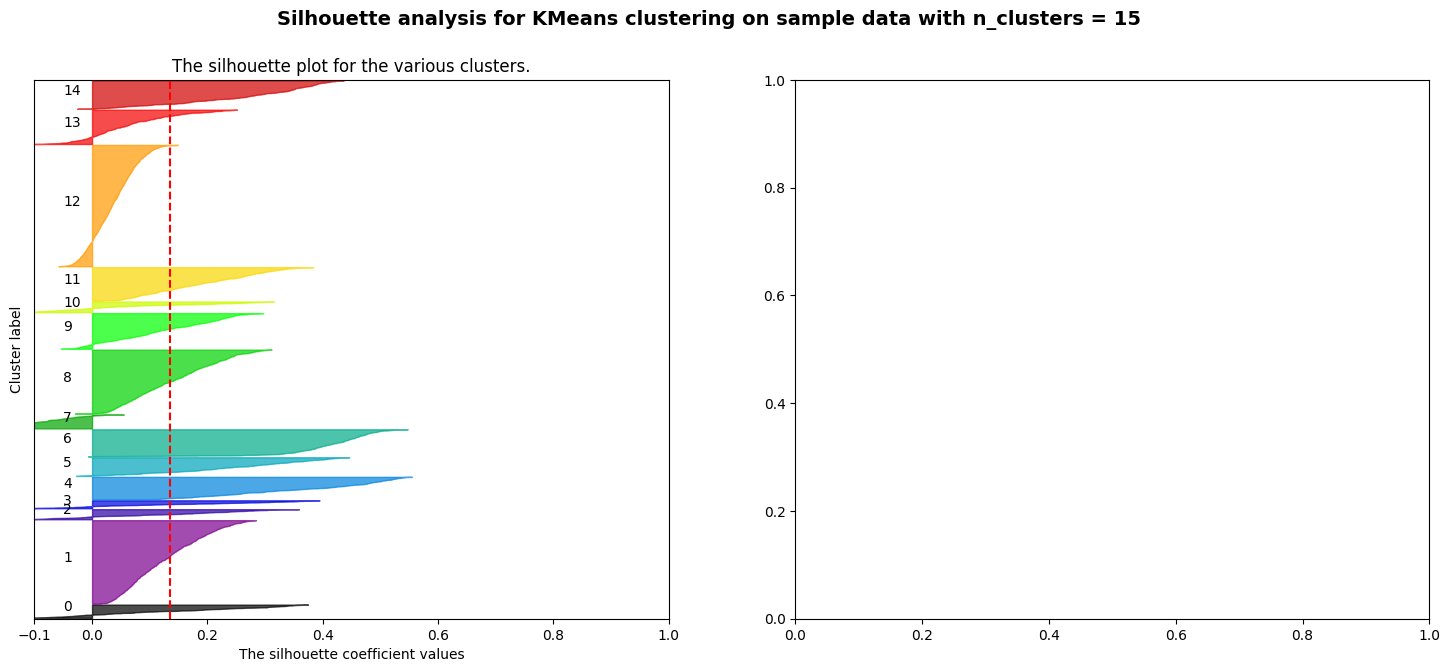

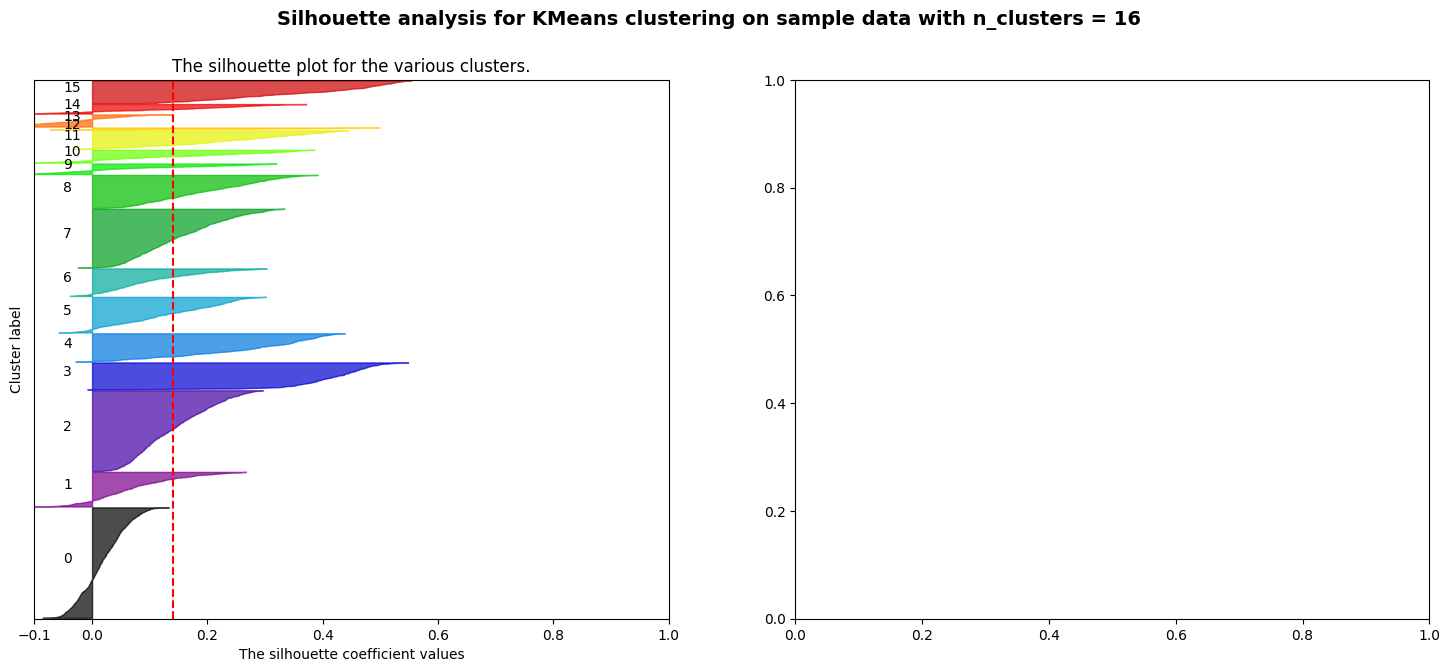

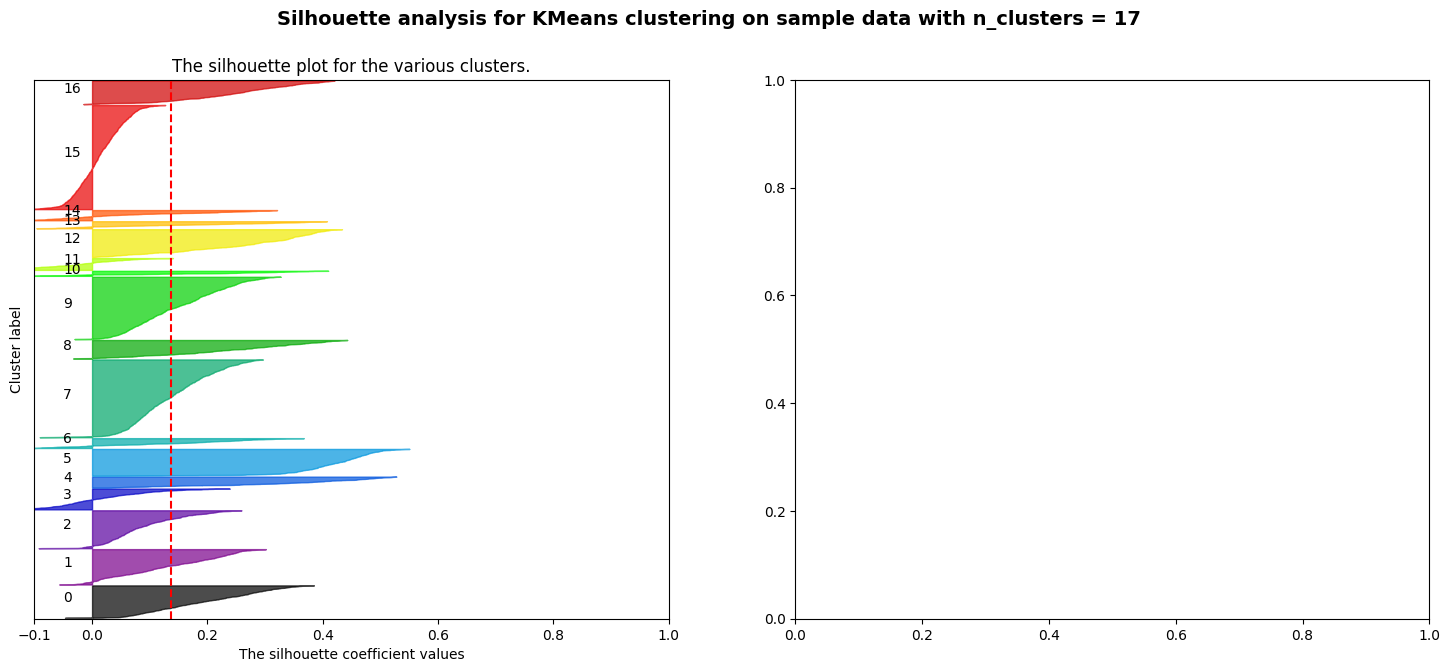

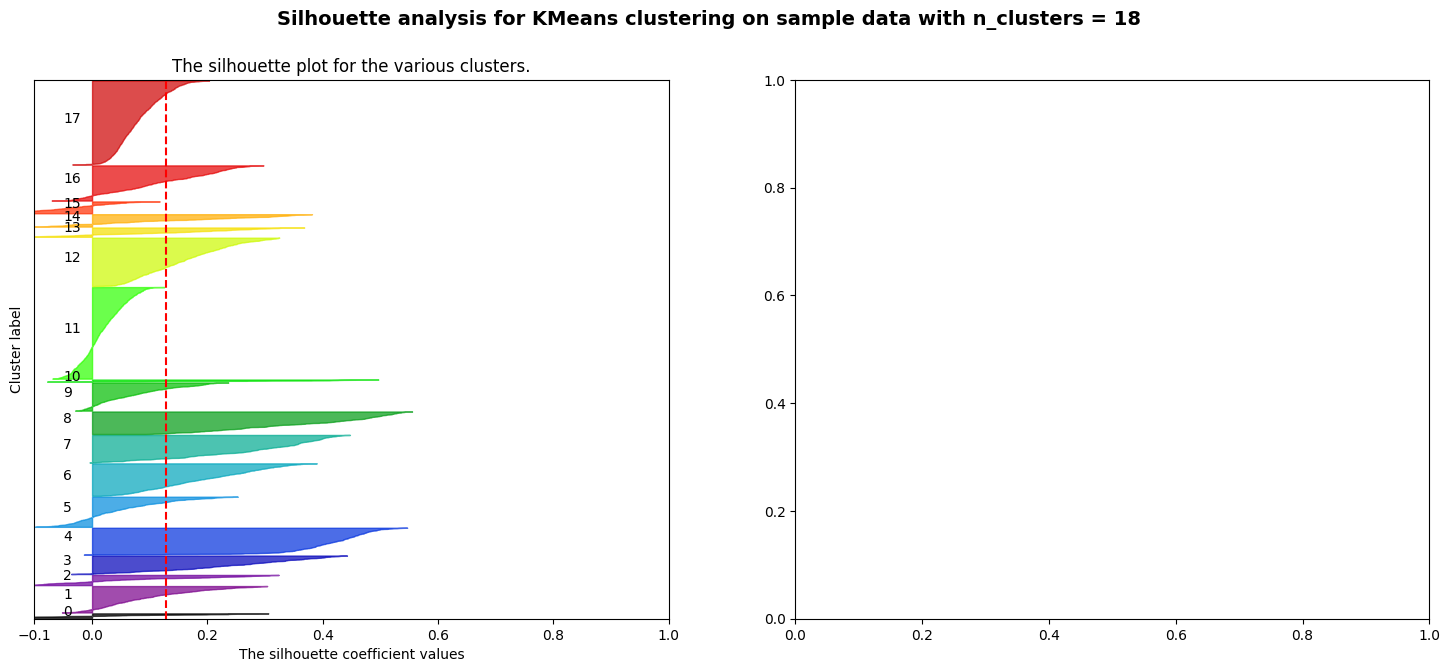

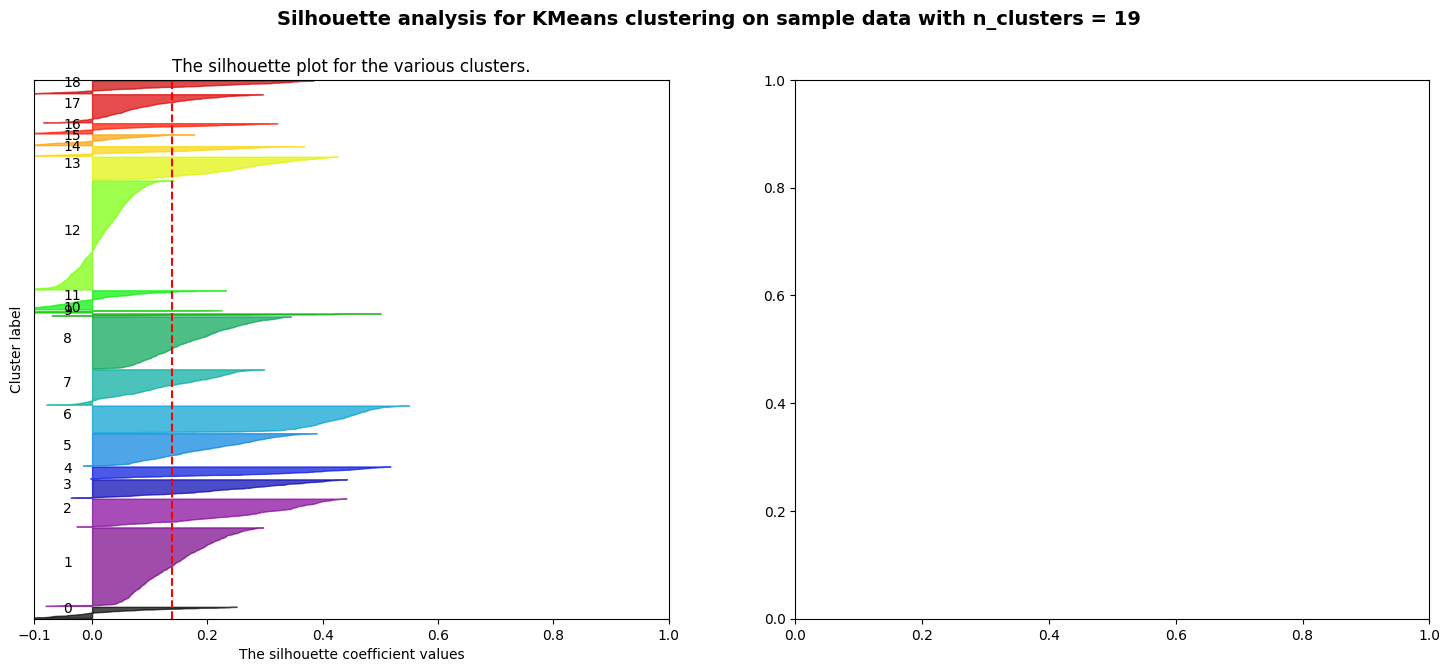

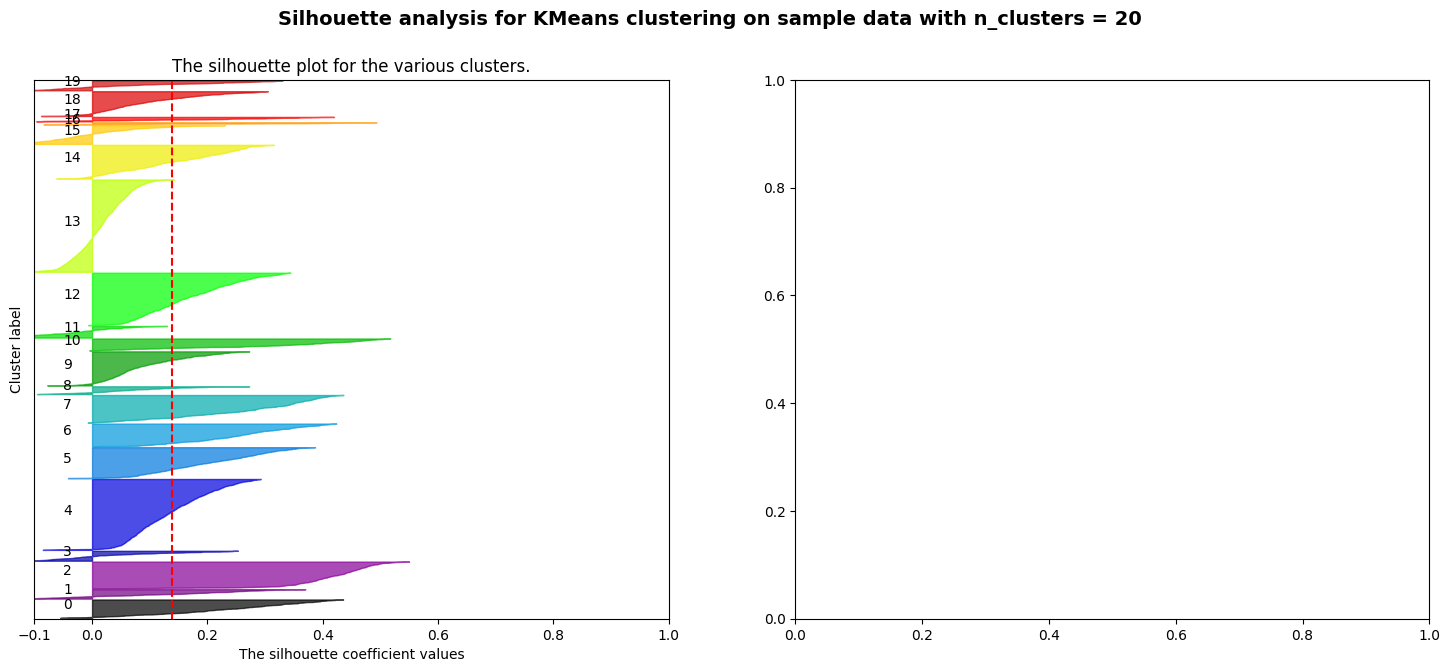

In [10]:
df_clustered = df_label.copy(deep = True)
res = df_clustered.drop(TARGET, axis=1)
range_n_clusters = list([*range(2, 21)])

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(res) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(res)
    df_clustered[f"Clusters_{n_clusters}"] = cluster_labels

    silhouette_avg = silhouette_score(res, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(res, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [11]:
df_clustered.head()

tumour_type      SBS1      SBS2  \
Unnamed: 0                                                              
003819bc-c415-4e76-887c-931d60ed39e7            1  0.004316  0.003587   
0040b1b6-b07a-4b6e-90ef-133523eaf412            1  0.003217  0.000678   
00493087-9d9d-40ca-86d5-936f1b951c93            1  0.091871  0.000089   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa            1  0.018977  0.001370   
005794f1-5a87-45b5-9811-83ddf6924568            1  0.004149  0.001245   

                                          SBS3      SBS4      SBS5      SBS6  \
Unnamed: 0                                                                     
003819bc-c415-4e76-887c-931d60ed39e7  0.000254  0.010579  0.086123  0.000176   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.015799  0.014538  0.014367  0.004027   
00493087-9d9d-40ca-86d5-936f1b951c93  0.011195  0.061277  0.055128  0.023751   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.024589  0.011517  0.031549  0.110884   
005794f1-5a87-45b5-9811-83ddf6924568  0.071443  0.027644  0.041967  0.000223   

                                         SBS7a     SBS7b     SBS7c  ...  \
Unnamed: 0                                                          ...   
003819bc-c415-4e76-887c-931d60ed39e7  0.000167  0.002125  0.054186  ...   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.000527  0.001565  0.000627  ...   
00493087-9d9d-40ca-86d5-936f1b951c93  0.000442  0.000266  0.001722  ...   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.006500  0.009127  0.000110  ...   
005794f1-5a87-45b5-9811-83ddf6924568  0.000772  0.003687  0.026620  ...   

                                      Clusters_11  Clusters_12  Clusters_13  \
Unnamed: 0                                                                    
003819bc-c415-4e76-887c-931d60ed39e7           10            9           10   
0040b1b6-b07a-4b6e-90ef-133523eaf412            1            1            0   
00493087-9d9d-40ca-86d5-936f1b951c93            7            7            4   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa            7            9            4   
005794f1-5a87-45b5-9811-83ddf6924568            6           11            9   

                                      Clusters_14  Clusters_15  Clusters_16  \
Unnamed: 0                                                                    
003819bc-c415-4e76-887c-931d60ed39e7            9           12            0   
0040b1b6-b07a-4b6e-90ef-133523eaf412            2            9            5   
00493087-9d9d-40ca-86d5-936f1b951c93           10            1            2   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa            9            7           13   
005794f1-5a87-45b5-9811-83ddf6924568            0            8            7   

                                      Clusters_17  Clusters_18  Clusters_19  \
Unnamed: 0                                                                    
003819bc-c415-4e76-887c-931d60ed39e7           15           11           12   
0040b1b6-b07a-4b6e-90ef-133523eaf412            1           16            7   
00493087-9d9d-40ca-86d5-936f1b951c93            7           17            1   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa           11           15           15   
005794f1-5a87-45b5-9811-83ddf6924568            2           11           12   

                                      Clusters_20  
Unnamed: 0                                         
003819bc-c415-4e76-887c-931d60ed39e7           13  
0040b1b6-b07a-4b6e-90ef-133523eaf412           14  
00493087-9d9d-40ca-86d5-936f1b951c93            4  
00508f2b-36bf-44fc-b66b-97e1f3e40bfa           11  
005794f1-5a87-45b5-9811-83ddf6924568            9  

[5 rows x 98 columns]

### Setup before modelling

In [12]:
plt.rcParams["figure.figsize"] = (10, 10)
RANDOM_STATE = 100
MODELS = [
    GradientBoostingClassifier, RandomForestClassifier, LogisticRegression,
    KNeighborsClassifier, SVC, LinearSVC, LGBMClassifier, XGBClassifier
]
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)
scorers = {
  'roc_auc': make_scorer(roc_auc_score),
  'accuracy': make_scorer(accuracy_score),
  'f1': make_scorer(f1_score),
  'precision': make_scorer(precision_score),
  'recall': make_scorer(recall_score),
}

In [13]:
def model_metrics(y_true, y_predicted):
    print(f"Accuracy : {accuracy_score(y_true, y_predicted)}")
    print(f"Precision : {precision_score(y_true, y_predicted)}")
    print(f"Recall : {recall_score(y_true, y_predicted)}")
    print(f"F1 Score : {f1_score(y_true, y_predicted)}")
    print(f"AUC Score : {roc_auc_score(y_true, y_predicted)}")

def scatter_predicted_vs_true(X, y_true, y_predicted):
    pred = pd.DataFrame(data = X, columns = ["PC1", "PC2"])
    pred["match"] = (y_test == y_pred).astype(int).values
    fig = sns.scatterplot(data = pred, x = "PC1", y = "PC2", hue = "match")
    plt.show(fig)

def cv_model(model_type, model_name, X_train, y_train, **kwargs):
    model = model_type(**kwargs)
    cv_results = cross_validate(model, X_train, y_train, scoring = scorers, cv = cv)
    print(f"Model - {model_name}, Results - {cv_results['test_roc_auc']}, Mean - {cv_results['test_roc_auc'].mean()}")
    score = cv_results['test_roc_auc'].mean()
    if np.isnan(score):
        score = 0
    return score

In [14]:
def fit_cv(X_train, y_train):
    scores = dict()
    model_names = [str(model_cls.__name__) for model_cls in MODELS]

    for model_cls in MODELS:
        model_name = str(model_cls.__name__)
        scores[model_name] = cv_model(model_cls, model_name, X_train, y_train)
    scores = dict(sorted(scores.items(), key=lambda item: item[1]))

    best_model_name = None
    for i, model_name in enumerate(scores):
        print(f"{i + 1}. {model_name} - {scores[model_name]}")
        best_model_name = model_name
    best_model_cls = MODELS[model_names.index(best_model_name)]
    
    return best_model_cls

In [15]:
X, y = df_label.drop(TARGET, axis=1), df_label[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y)
reducer = PCA(n_components = 2)
X_truncated = reducer.fit_transform(X_test)
reducer.explained_variance_ratio_.sum()

0.2205995142207069

### Modelling - default

In [15]:
X, y = df_label.drop(TARGET, axis=1), df_label[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y)
X_train.shape, X_test.shape

((4622, 78), (1541, 78))

In [ ]:
best_model = fit_cv(X_train, y_train)
best_model

In [ ]:
grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.3],
    'reg_alpha': [0, 0.5, 2],
    'reg_lambda': [0, 0.5, 2],
    'colsample_bytree': [0.4, 0.7, 1],
    'subsample': [0.6, 0.8, 1]
}
fit_kwargs = {"eval_metric" : "auc", "eval_set": [(X_train, y_train), (X_test, y_test)], "early_stopping_rounds": 20}
cv_estimator = GridSearchCV(best_model(), grid, cv = cv, scoring = scorers['roc_auc'], n_jobs = -1)
cv_estimator.fit(X_train, y_train, **fit_kwargs)
cv_estimator.score(X_test, y_test)

In [ ]:
y_pred = cv_estimator.predict(X_test)
model_metrics(y_test, y_pred)
scatter_predicted_vs_true(X_truncated, y_test, y_pred)

In [ ]:
cv_estimator.best_params_

In [ ]:
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'reg_alpha': 2,
    'reg_lambda': 0,
    'subsample': 0.6
}
fit_kwargs = {
    "eval_metric" : "auc", 
    "eval_set": [(X_train, y_train), (X_test, y_test)], 
    "early_stopping_rounds": 20
}
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train, **fit_kwargs)
model.score(X_test, y_test)

In [ ]:
feature_imp = sorted([(imp, col) for imp, col in zip(model.feature_importances_, X.columns) if imp > 0])
feature_imp = pd.DataFrame(feature_imp, columns=['Value','Feature'])
plt.figure(figsize=(28, 30))
sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
plt.tight_layout()
plt.show()

### Modelling - additional features

In [ ]:
X, y = df_label_add_features.drop(TARGET, axis=1), df_label_add_features[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y)
X_train.shape, X_test.shape

In [ ]:
best_model = fit_cv(X_train, y_train)
best_model

In [ ]:
grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.3],
    'reg_alpha': [0, 0.5, 2],
    'reg_lambda': [0, 0.5, 2],
    'colsample_bytree': [0.4, 0.7, 1],
    'subsample': [0.6, 0.8, 1]
}
fit_kwargs = {"eval_metric" : "auc", "eval_set": [(X_train, y_train), (X_test, y_test)], "early_stopping_rounds": 20}
cv_estimator = GridSearchCV(best_model(), grid, cv = cv, scoring = scorers['roc_auc'])
cv_estimator.fit(X_train, y_train, **fit_kwargs)
cv_estimator.score(X_test, y_test)

In [ ]:
y_pred = cv_estimator.predict(X_test)
model_metrics(y_test, y_pred)
scatter_predicted_vs_true(X_truncated, y_test, y_pred)

In [ ]:
cv_estimator.best_params_

In [ ]:
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'reg_alpha': 2,
    'reg_lambda': 2,
    'subsample': 0.6
}
fit_kwargs = {
    "eval_metric" : "auc", 
    "eval_set": [(X_train, y_train), (X_test, y_test)], 
    "early_stopping_rounds": 20
}
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train, **fit_kwargs)
model.score(X_test, y_test)

In [ ]:
feature_imp = sorted([(imp, col) for imp, col in zip(model.feature_importances_, X.columns) if imp > 0])
feature_imp = pd.DataFrame(feature_imp, columns=['Value','Feature'])
plt.figure(figsize=(28, 30))
sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
plt.tight_layout()
plt.show()

### Modelling - with clustering

In [16]:
X, y = df_clustered.drop(TARGET, axis=1), df_clustered[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y)
X_train.shape, X_test.shape

((4622, 97), (1541, 97))

In [16]:
best_model = fit_cv(X_train, y_train)
best_model

Model - GradientBoostingClassifier, Results - [0.74946838 0.7416353  0.72430135 0.73746759 0.72180103], Mean - 0.7349347287929837
Model - RandomForestClassifier, Results - [0.75033526 0.76268954 0.73140305 0.74737828 0.71344222], Mean - 0.741049671102343
Model - LogisticRegression, Results - [0.63967595 0.6327313  0.63431288 0.61637857 0.62537487], Mean - 0.6296947142223954
Model - KNeighborsClassifier, Results - [0.61617671 0.66721505 0.6264333  0.64719101 0.59979463], Mean - 0.6313621417132941
Model - SVC, Results - [0.63778174 0.64287527 0.62314895 0.61925958 0.61353483], Mean - 0.627320074594022
Model - LinearSVC, Results - [0.6841073  0.64419715 0.52490637 0.59938058 0.60977049], Mean - 0.612472378989275
Model - LGBMClassifier, Results - [0.7669593  0.75688957 0.74255258 0.75433593 0.7419159 ], Mean - 0.7525306546928908
Model - XGBClassifier, Results - [0.75597479 0.75510791 0.72667819 0.75079228 0.74063713], Mean - 0.7458380588991715
1. LinearSVC - 0.612472378989275
2. SVC - 0.62

lightgbm.sklearn.LGBMClassifier

In [41]:
grid = {
    'n_estimators' : [1000],
    'learning_rate': [0.05, 0.1, 0.3],
    'reg_alpha': [0, 0.5, 2],
    'reg_lambda': [0, 0.5, 2],
    'colsample_bytree': [0.4, 0.7, 1],
    'subsample': [0.6, 0.8, 1]
}
fit_kwargs = {"eval_metric" : "auc", "eval_set": [(X_train, y_train), (X_test, y_test)], "early_stopping_rounds": 20, "verbose" : -100}
with ProgressBar():
    cv_estimator = DaskGridSearchCV(best_model(), grid, cv = cv, scoring = scorers['roc_auc'], n_jobs = -1)
    cv_estimator.fit(X_train, y_train, **fit_kwargs)
cv_estimator.score(X_test, y_test)

[########################################] | 100% Completed |  1hr 16min 38.1s
[########################################] | 100% Completed |  3.7s


0.7516310257339615

Accuracy : 0.763140817650876
Precision : 0.7399328859060402
Recall : 0.6774193548387096
F1 Score : 0.7072975140336808
AUC Score : 0.7516310257339615


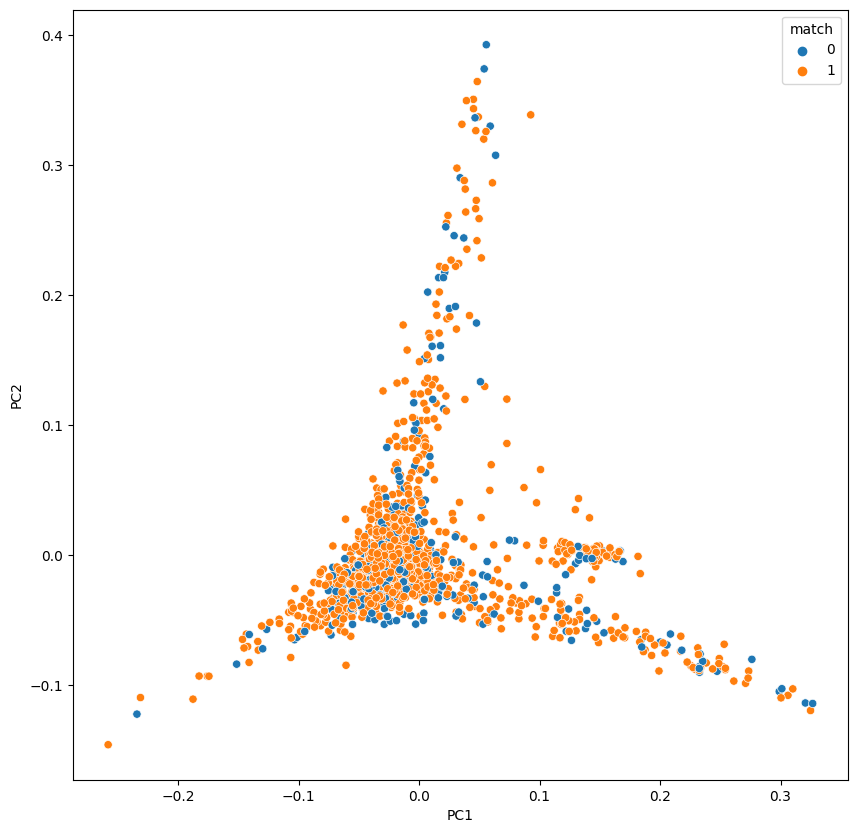

In [42]:
y_pred = cv_estimator.predict(X_test)
model_metrics(y_test, y_pred)
scatter_predicted_vs_true(X_truncated, y_test, y_pred)

In [43]:
cv_estimator.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.05,
 'n_estimators': 1000,
 'reg_alpha': 2,
 'reg_lambda': 0,
 'subsample': 0.6}

In [17]:
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'reg_alpha': 2,
    'reg_lambda': 0,
    'subsample': 0.6
}
fit_kwargs = {
    "eval_metric" : "auc", 
    "eval_set": [(X_train, y_train), (X_test, y_test)], 
    "early_stopping_rounds": 20
}
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train, **fit_kwargs)
model.score(X_test, y_test)

[1]	training's auc: 0.822744	training's binary_logloss: 0.666131	valid_1's auc: 0.751861	valid_1's binary_logloss: 0.66982
[2]	training's auc: 0.831957	training's binary_logloss: 0.6525	valid_1's auc: 0.761202	valid_1's binary_logloss: 0.659709
[3]	training's auc: 0.844005	training's binary_logloss: 0.639735	valid_1's auc: 0.771303	valid_1's binary_logloss: 0.65008
[4]	training's auc: 0.854166	training's binary_logloss: 0.628024	valid_1's auc: 0.782053	valid_1's binary_logloss: 0.641192
[5]	training's auc: 0.86236	training's binary_logloss: 0.616597	valid_1's auc: 0.787743	valid_1's binary_logloss: 0.633257
[6]	training's auc: 0.869523	training's binary_logloss: 0.606122	valid_1's auc: 0.7893	valid_1's binary_logloss: 0.626646
[7]	training's auc: 0.876031	training's binary_logloss: 0.596314	valid_1's auc: 0.792313	valid_1's binary_logloss: 0.620081
[8]	training's auc: 0.877786	training's binary_logloss: 0.587067	valid_1's auc: 0.794706	valid_1's binary_logloss: 0.613403
[9]	training's 

0.7676833225178455

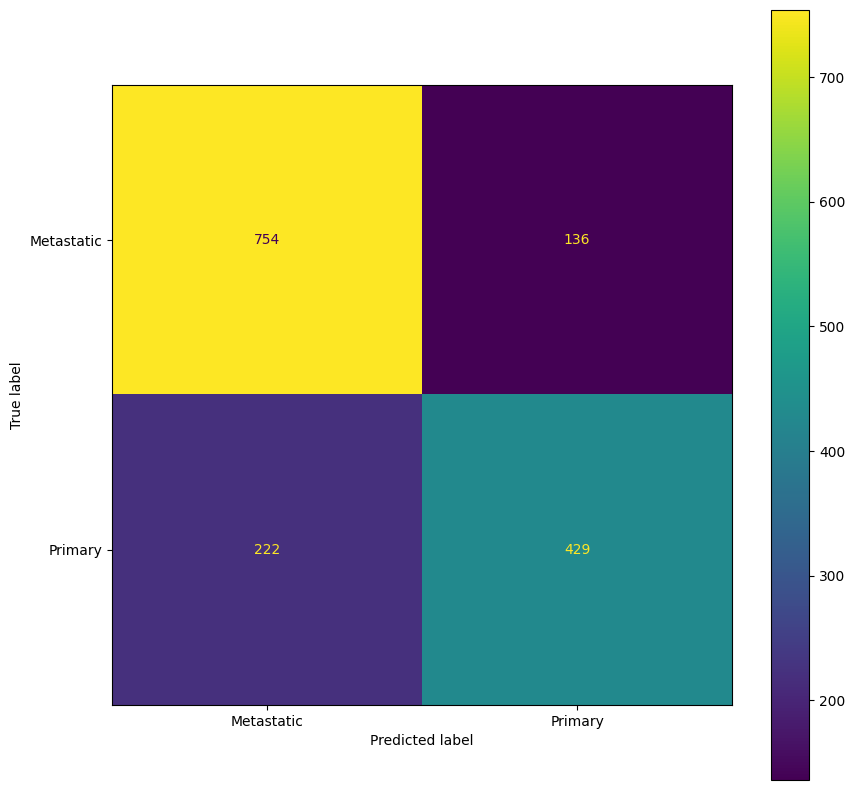

In [29]:
y_score = pd.Series(model.predict(X_test), index = X_test.index)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test[y_test == 1] = "Primary"
y_test[y_test == 0] = "Metastatic"
y_score[y_score == 1] = "Primary"
y_score[y_score == 0] = "Metastatic"
cm = confusion_matrix(y_test, y_score, labels = ["Metastatic", "Primary"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Metastatic", "Primary"])
disp.plot()

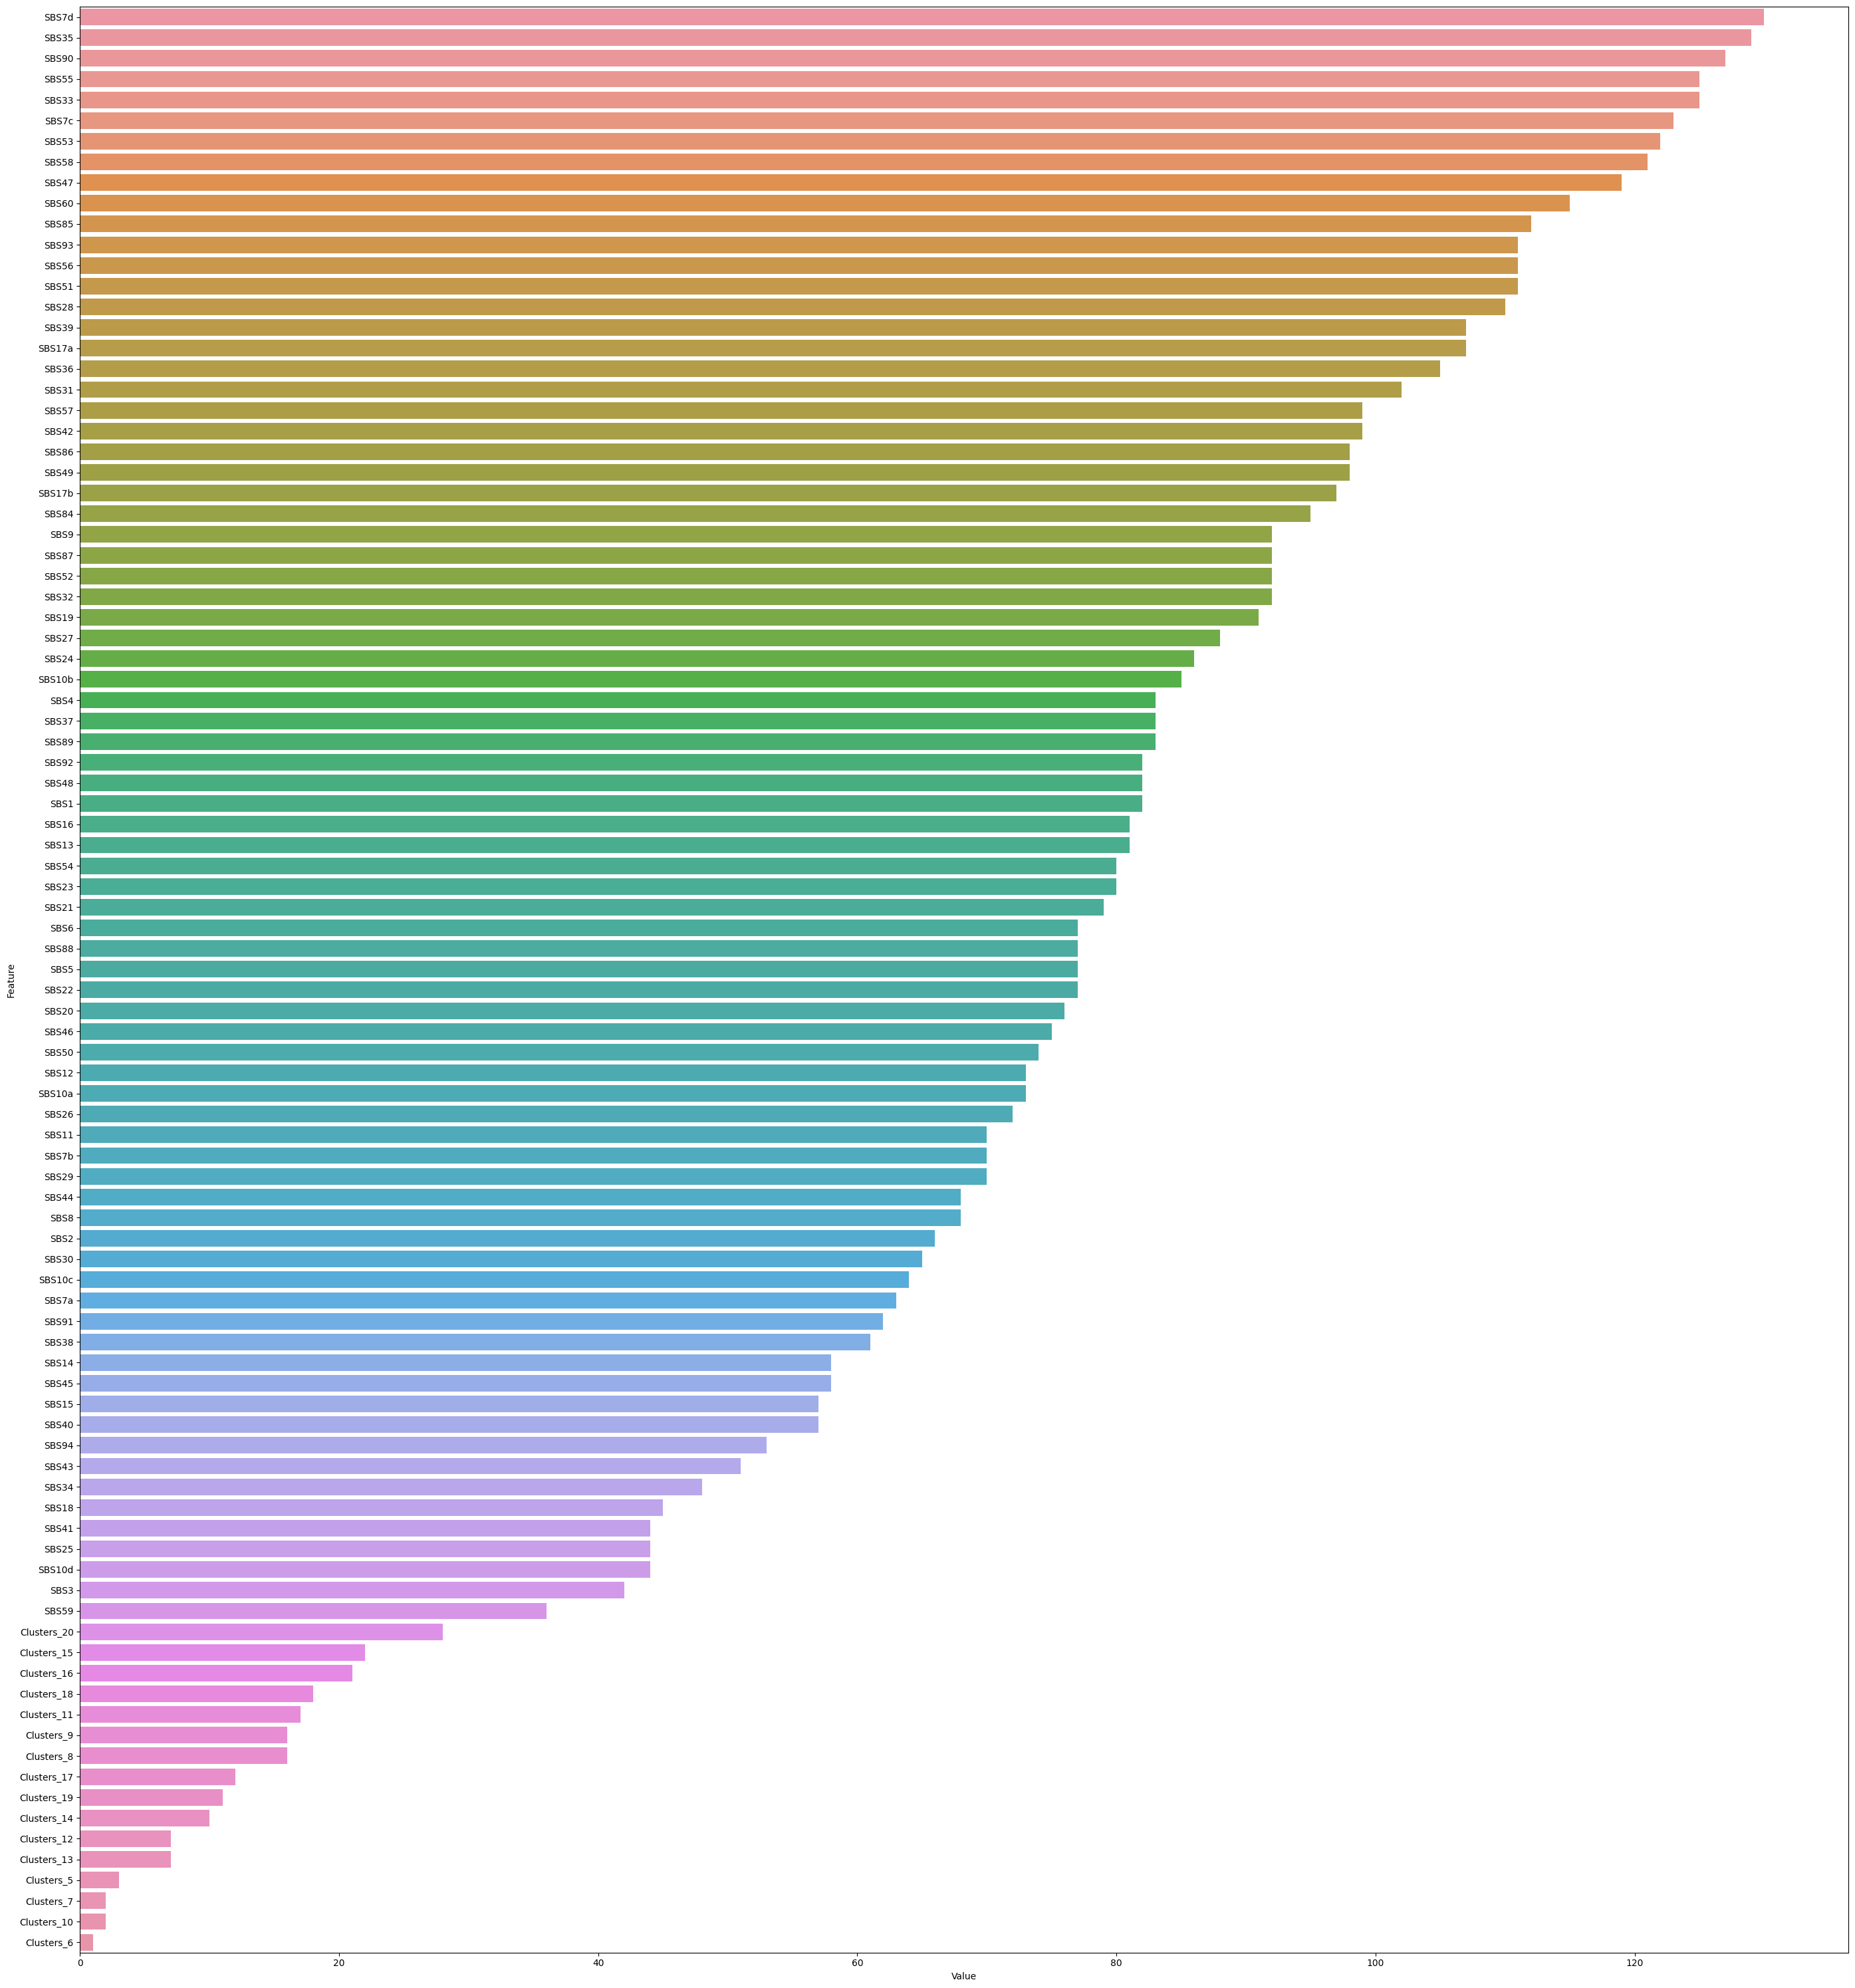

In [20]:
feature_imp = sorted([(imp, col) for imp, col in zip(model.feature_importances_, X.columns) if imp > 0])
feature_imp = pd.DataFrame(feature_imp, columns=['Value','Feature'])
plt.figure(figsize=(28, 30))
sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
plt.tight_layout()
plt.show()

## (Non-related) Get AUC for each of the organ types

In [31]:
df_organs = pd.read_csv(f"{DIR_PATH}/phg_clincal_activities.csv").set_index("Unnamed: 0")
df_organs.head()

pcawg_class    WGD  num_subclones  \
Unnamed: 0                                                                   
0009b464-b376-4fbc-8a56-da538269a02f   Ovary-AdenoCA   True            1.0   
003819bc-c415-4e76-887c-931d60ed39e7   CNS-PiloAstro  False            1.0   
0040b1b6-b07a-4b6e-90ef-133523eaf412       Liver-HCC  False            1.0   
00493087-9d9d-40ca-86d5-936f1b951c93       CNS-Oligo  False            1.0   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  Panc-Endocrine  False            2.0   

                                     tumour_type reported_sex  \
Unnamed: 0                                                      
0009b464-b376-4fbc-8a56-da538269a02f   Recurrent       Female   
003819bc-c415-4e76-887c-931d60ed39e7     Primary       Female   
0040b1b6-b07a-4b6e-90ef-133523eaf412     Primary         Male   
00493087-9d9d-40ca-86d5-936f1b951c93     Primary       Female   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa     Primary       Female   

                                      donor_survival_time  \
Unnamed: 0                                                  
0009b464-b376-4fbc-8a56-da538269a02f               1972.0   
003819bc-c415-4e76-887c-931d60ed39e7                244.0   
0040b1b6-b07a-4b6e-90ef-133523eaf412               1905.0   
00493087-9d9d-40ca-86d5-936f1b951c93                  NaN   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa                  7.0   

                                      donor_age_at_diagnosis tumour_stage  \
Unnamed: 0                                                                  
0009b464-b376-4fbc-8a56-da538269a02f                    54.0          NaN   
003819bc-c415-4e76-887c-931d60ed39e7                     4.0          NaN   
0040b1b6-b07a-4b6e-90ef-133523eaf412                    73.0          NaN   
00493087-9d9d-40ca-86d5-936f1b951c93                    47.0          NaN   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa                    59.0       T2N1MX   

                                                       tumour_grade  \
Unnamed: 0                                                            
0009b464-b376-4fbc-8a56-da538269a02f                            NaN   
003819bc-c415-4e76-887c-931d60ed39e7                              1   
0040b1b6-b07a-4b6e-90ef-133523eaf412                             G2   
00493087-9d9d-40ca-86d5-936f1b951c93                            NaN   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  2 - Moderately differentiated   

                                     first_therapy_type  ...     SBS85  \
Unnamed: 0                                               ...             
0009b464-b376-4fbc-8a56-da538269a02f                NaN  ...  0.004170   
003819bc-c415-4e76-887c-931d60ed39e7                NaN  ...  0.011223   
0040b1b6-b07a-4b6e-90ef-133523eaf412       no treatment  ...  0.010256   
00493087-9d9d-40ca-86d5-936f1b951c93                NaN  ...  0.034194   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa                NaN  ...  0.002131   

                                         SBS86     SBS87     SBS88     SBS89  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.032632  0.009180  0.004538  0.015247   
003819bc-c415-4e76-887c-931d60ed39e7  0.000018  0.043297  0.002587  0.000110   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.001064  0.000472  0.006128  0.014017   
00493087-9d9d-40ca-86d5-936f1b951c93  0.007644  0.066593  0.003875  0.008409   
00508f2b-36bf-44fc-b66b-97e1f3e40bfa  0.006881  0.014572  0.005315  0.034945   

                                         SBS90     SBS91     SBS92     SBS93  \
Unnamed: 0                                                                     
0009b464-b376-4fbc-8a56-da538269a02f  0.023516  0.001096  0.001524  0.041314   
003819bc-c415-4e76-887c-931d60ed39e7  0.001679  0.000330  0.008414  0.012260   
0040b1b6-b07a-4b6e-90ef-133523eaf412  0.003671  0.002160  0.015290  0.010472   
00493087-9d9d-40ca-86d5-936f1b951c93  0.001092  0.004163  0.013443  0.012461   
00508f2b-36b

In [36]:
from sklearn.metrics import confusion_matrix
results = list()

for organ in df_organs["organ"].unique():
    if organ == "Oral_Oropharyngeal":
        continue
    organs_index = df_organs[df_organs["organ"] == organ].index
    organs_index = df_clustered.index.intersection(organs_index)
    
    X, y_true = df_clustered.loc[organs_index].drop(TARGET, axis = 1), df_clustered.loc[organs_index][TARGET]
    y_score_probs = model.predict_proba(X)
    y_score = model.predict(X)
    try:
        roc_auc_score_organ = roc_auc_score(y_true, y_score_probs[:, 1])
    except:
        roc_auc_score_organ = model.score(X, y_true)
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    results.append([organ, roc_auc_score_organ, tn, fp, fn, tp])
    pred_csv = pd.DataFrame(data = {"y_true": y_true, "y_score": y_score_probs[:, 1]})
    pred_csv.to_csv(f"./Results/Classification/{organ}_pred.csv")

results = pd.DataFrame(data = results, columns=["Organ", "ROC-AUC", "TN", "FP", "FN", "TP"])
results[["ROC-AUC", "TN", "FP", "FN", "TP"]].mean()

ROC-AUC      0.922132
TN         161.666667
FP           7.809524
FN          13.095238
TP         110.904762
dtype: float64

In [37]:
results.to_csv("./Results/Classification/AUC_for_each_organ.csv")